In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 31
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-100"
number_of_opt_evaluations = 100
run_i = 7


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


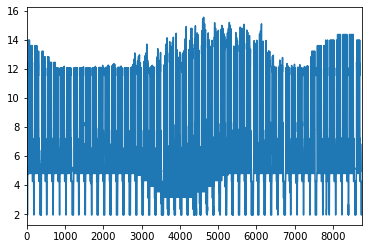

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.193297863006592 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.964949369430542 sec


ERROR:root:Finished Generation of Irradiance


0.0


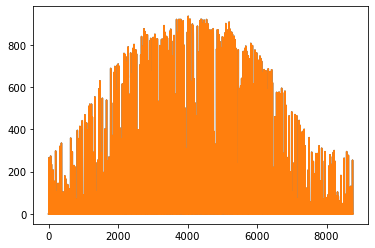

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.842372417449951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.876375436782837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8788294792175293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 184s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


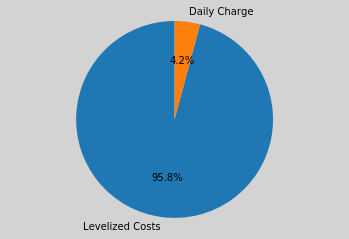

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (148.96051930111315, 218.67406785658093, 165.2134664200771, 32.14225725289841, 28.873631176668937, 14.312461422935758, 0.7118372908889798, 0.6149413039517824, 0.818856283453919)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 32.1
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.906341791152954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 28.9
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8798210620880127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 14.3
                                           and a gcr of 0.819


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 150.0830090045929 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 169 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 155 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.594]


ERROR:ga_logger:Cost: 3267.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,268 per year


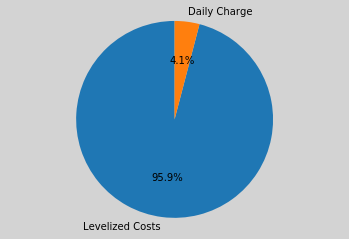

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.4%
succes
[[148.96051930111315, 218.67406785658093, 165.2134664200771, 32.14225725289841, 28.873631176668937, 14.312461422935758, 0.7118372908889798, 0.6149413039517824, 0.818856283453919, 3267.6, 315.594, 0.0, 0.0, 315.594, {'Levelized Costs': 3134.538, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601973828554, 61845.7, 385.408]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (189.33919015010105, 229.69466817219717, 118.57247945574265, 10.659012933429876, 29.110930648120707, 28.4201588950387, 0.24549626444295194, 0.664178093172713, 0.872738357882473)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 10.7
                                           and a gcr of 0.245


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.711315393447876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 29.1
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.889639139175415 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 28.4
                                           and a gcr of 0.873


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8663864135742188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [41.3267, 285.877, 0.0]


ERROR:ga_logger:Cost: 3382.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,383 per year


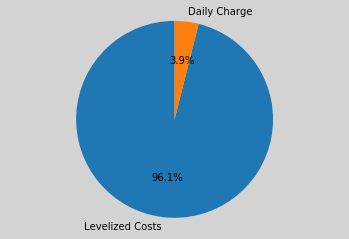

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[189.33919015010105, 229.69466817219717, 118.57247945574265, 10.659012933429876, 29.110930648120707, 28.4201588950387, 0.24549626444295194, 0.664178093172713, 0.872738357882473, 3382.91, 327.2037, 41.3267, 285.877, 0.0, {'Levelized Costs': 3249.8569999999995, 'Energy Charge': 0.011000000000478849, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60295089398, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.56310576853306, 187.7621922885039, 178.20378910628267, 23.55914141769589, 12.373565552074862, 10.405279600569646, 0.3580858968604115, 0.393887106143219, 0.3320330658267106)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 23.6
                                           and a gcr of 0.358


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8665904998779297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 12.4
                                           and a gcr of 0.394


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8777403831481934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 10.4
                                           and a gcr of 0.332


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8823986053466797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 283 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 235.845, 0.0]


ERROR:ga_logger:Cost: 4292.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0294 /kWh
Total Cost of the system: $ 4,292 per year


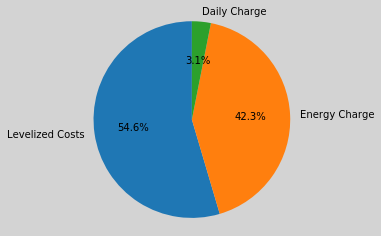

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.56310576853306, 187.7621922885039, 178.20378910628267, 23.55914141769589, 12.373565552074862, 10.405279600569646, 0.3580858968604115, 0.393887106143219, 0.3320330658267106, 4292.11, 235.845, 0.0, 235.845, 0.0, {'Levelized Costs': 2342.4509999999996, 'Energy Charge': 1816.6170000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 47347.57600119792, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (233.45359072459672, 203.7488345954381, 236.92398356237757, 28.41096681332063, 40.927343243839886, 10.30517400617352, 0.6230590785597689, 0.7353874738270829, 0.527592542791201)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 28.4
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9674880504608154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 40.9
                                           and a gcr of 0.735


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9472010135650635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 10.3
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191431760787964 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 344s


ERROR:ga_logger:panel relevance: [0.0, 324.467, 0.0]


ERROR:ga_logger:Cost: 3355.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


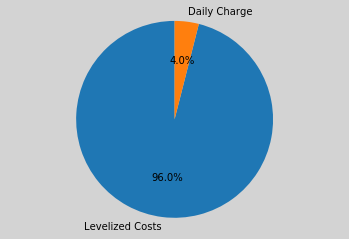

Total roof area of the  building: 599 m2
Total roof area used 441 m2
Percentage: 73.7%
succes
[[233.45359072459672, 203.7488345954381, 236.92398356237757, 28.41096681332063, 40.927343243839886, 10.30517400617352, 0.6230590785597689, 0.7353874738270829, 0.527592542791201, 3355.73, 324.467, 0.0, 324.467, 0.0, {'Levelized Costs': 3222.671, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60093014007, 61845.7, 441.22]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (187.06806749412033, 90.19113747326503, 199.15835353762733, 36.26922878883212, 16.212962534466204, 34.11657486691365, 0.6961801532338552, 0.4315668941568508, 0.28018109226142085)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 36.3
                                           and a gcr of 0.696


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.883303642272949 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 16.2
                                           and a gcr of 0.432


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8789143562316895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 34.1
                                           and a gcr of 0.280


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9593968391418457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [227.178, 0.0, 76.3329]


ERROR:ga_logger:Cost: 3147.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,148 per year


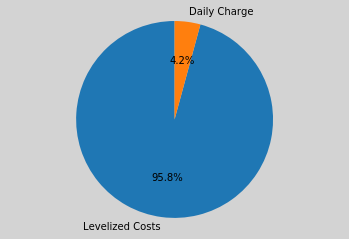

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[187.06806749412033, 90.19113747326503, 199.15835353762733, 36.26922878883212, 16.212962534466204, 34.11657486691365, 0.6961801532338552, 0.4315668941568508, 0.28018109226142085, 3147.59, 303.5109, 227.178, 0.0, 76.3329, {'Levelized Costs': 3014.533, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60144657176, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (119.23552344510735, 92.65697638360987, 102.69450967207513, 4.268529308270534, 9.119301476321741, 8.667024443369113, 0.33409638997756996, 0.5868699446391381, 0.7430585011597501)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 4.3
                                           and a gcr of 0.334


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.87152361869812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 9.1
                                           and a gcr of 0.587


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1466057300567627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 103
                                           a tilt of 8.7
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9460017681121826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [91.6167, 0.0, 241.152]


ERROR:ga_logger:Cost: 3438.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,438 per year


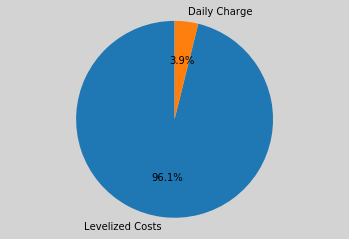

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[119.23552344510735, 92.65697638360987, 102.69450967207513, 4.268529308270534, 9.119301476321741, 8.667024443369113, 0.33409638997756996, 0.5868699446391381, 0.7430585011597501, 3438.18, 332.76869999999997, 91.6167, 0.0, 241.152, {'Levelized Costs': 3305.1229999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60075855999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190.29135929134688, 99.80437120025941, 232.67567350195375, 19.451185301718564, 7.311179217462122, 41.246898946428715, 0.6285015440948372, 0.42897168982820844, 0.2241632225869405)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 19.5
                                           and a gcr of 0.629


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.718090057373047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 7.3
                                           and a gcr of 0.429


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8871665000915527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 41.2
                                           and a gcr of 0.224


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.883633852005005 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [303.107, 0.0, 0.0]


ERROR:ga_logger:Cost: 3143.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,144 per year


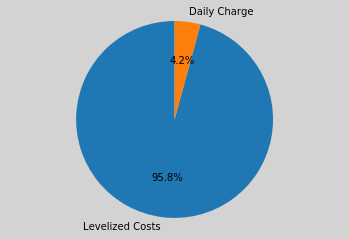

Total roof area of the  building: 599 m2
Total roof area used 482 m2
Percentage: 80.5%
succes
[[190.29135929134688, 99.80437120025941, 232.67567350195375, 19.451185301718564, 7.311179217462122, 41.246898946428715, 0.6285015440948372, 0.42897168982820844, 0.2241632225869405, 3143.58, 303.107, 303.107, 0.0, 0.0, {'Levelized Costs': 3010.5249999999996, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60066411388, 61845.7, 482.27]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (111.61602876658694, 258.1585338700929, 181.3113560561501, 12.851321889151029, 40.452536783499085, 34.54977482078044, 0.7048078717407422, 0.5795782333976469, 0.5191274076346631)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 12.9
                                           and a gcr of 0.705


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8830933570861816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 40.5
                                           and a gcr of 0.580


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.87394380569458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 34.5
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.866168975830078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 275 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 295.327]


ERROR:ga_logger:Cost: 3066.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,066 per year


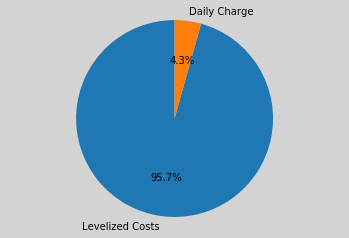

Total roof area of the  building: 599 m2
Total roof area used 569 m2
Percentage: 95.0%
succes
[[111.61602876658694, 258.1585338700929, 181.3113560561501, 12.851321889151029, 40.452536783499085, 34.54977482078044, 0.7048078717407422, 0.5795782333976469, 0.5191274076346631, 3066.3, 295.327, 0.0, 0.0, 295.327, {'Levelized Costs': 2933.24, 'Energy Charge': 0.018000000000427008, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60006707177, 61845.7, 568.891]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.2119634816668, 109.0922820466588, 117.4542354423327, 39.648085555828594, 24.12931244633166, 14.440619454931936, 0.41392383713862874, 0.8654713481199581, 0.3833149159687021)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 39.6
                                           and a gcr of 0.414


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5231895446777344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 24.1
                                           and a gcr of 0.865


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9154887199401855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 117
                                           a tilt of 14.4
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9176337718963623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [177.148, 147.813, 0.0]


ERROR:ga_logger:Cost: 3360.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,361 per year


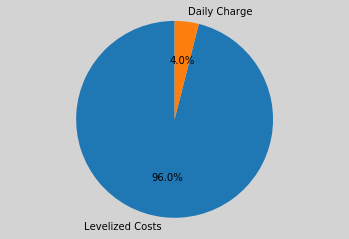

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.2119634816668, 109.0922820466588, 117.4542354423327, 39.648085555828594, 24.12931244633166, 14.440619454931936, 0.41392383713862874, 0.8654713481199581, 0.3833149159687021, 3360.64, 324.961, 177.148, 147.813, 0.0, {'Levelized Costs': 3227.586, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60073459015, 61845.7, 598.762]]


The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.98030762801508, 216.88026578303945, 204.03826641881312, 46.68205939911732, 43.4877184089234, 9.414228767065802, 0.5118011220078689, 0.6906125237695064, 0.7941017066489553)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 46.7
                                           and a gcr of 0.512


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0543272495269775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 43.5
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.877519369125366 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 9.4
                                           and a gcr of 0.794


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6539018154144287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 227s


ERROR:ga_logger:panel relevance: [290.057, 0.0, 25.4309]


ERROR:ga_logger:Cost: 3266.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,267 per year


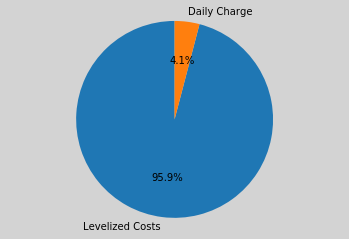

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[153.98030762801508, 216.88026578303945, 204.03826641881312, 46.68205939911732, 43.4877184089234, 9.414228767065802, 0.5118011220078689, 0.6906125237695064, 0.7941017066489553, 3266.54, 315.4879, 290.057, 0.0, 25.4309, {'Levelized Costs': 3133.484, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60238500146, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.02204729926325, 112.32878195710421, 190.0543487640975, 26.882699062770175, 38.128416963881236, 5.841346489980364, 0.5616576874355518, 0.8299006837314564, 0.8228096386294106)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 26.9
                                           and a gcr of 0.562


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 5.544740200042725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 38.1
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.367053270339966 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 5.8
                                           and a gcr of 0.823


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9617950916290283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  87 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [296.22, 0.0, 0.0]


ERROR:ga_logger:Cost: 3075.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,075 per year


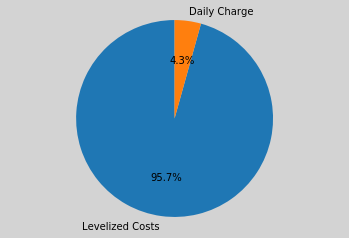

Total roof area of the  building: 599 m2
Total roof area used 527 m2
Percentage: 88.1%
succes
[[180.02204729926325, 112.32878195710421, 190.0543487640975, 26.882699062770175, 38.128416963881236, 5.841346489980364, 0.5616576874355518, 0.8299006837314564, 0.8228096386294106, 3075.18, 296.22, 296.22, 0.0, 0.0, {'Levelized Costs': 2942.1229999999996, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60295252228, 61845.7, 527.404]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.76607735268345, 160.66733183102676, 154.1390109778891, 33.92978290347351, 44.72868354076262, 3.4125698012579018, 0.4463569977296419, 0.7237148040293995, 0.2350807179963521)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 162
                                           a tilt of 33.9
                                           and a gcr of 0.446


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9340271949768066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 44.7
                                           and a gcr of 0.724


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8597638607025146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 3.4
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.806673288345337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [205.448, 100.224, 0.0]


ERROR:ga_logger:Cost: 3169.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,169 per year


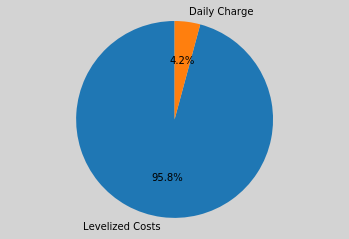

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.76607735268345, 160.66733183102676, 154.1390109778891, 33.92978290347351, 44.72868354076262, 3.4125698012579018, 0.4463569977296419, 0.7237148040293995, 0.2350807179963521, 3169.05, 305.672, 205.448, 100.224, 0.0, {'Levelized Costs': 3035.991, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602132199994, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.29645458615997, 261.80804003438925, 216.68009048655534, 2.494870404032433, 24.299606897517734, 24.00416228864035, 0.42314273808732406, 0.2705861067600543, 0.6492557379998694)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 227
                                           a tilt of 2.5
                                           and a gcr of 0.423


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7855207920074463 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 24.3
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9509084224700928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 217
                                           a tilt of 24.0
                                           and a gcr of 0.649


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.928110361099243 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 256 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 217s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.496]


ERROR:ga_logger:Cost: 3256.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,257 per year


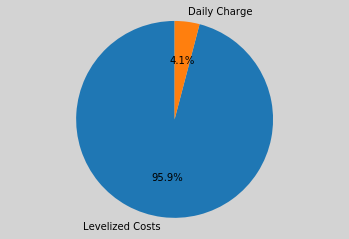

Total roof area of the  building: 599 m2
Total roof area used 484 m2
Percentage: 80.9%
succes
[[227.29645458615997, 261.80804003438925, 216.68009048655534, 2.494870404032433, 24.299606897517734, 24.00416228864035, 0.42314273808732406, 0.2705861067600543, 0.6492557379998694, 3256.69, 314.496, 0.0, 0.0, 314.496, {'Levelized Costs': 3123.635, 'Energy Charge': 0.013000000000090495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60135643056, 61845.7, 484.394]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (116.6866679641773, 252.40421113286544, 190.19079144234263, 52.9769392970219, 15.670805473859241, 2.9934459274807788, 0.5793199258722336, 0.7069379884749725, 0.3356427070750201)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 53.0
                                           and a gcr of 0.579


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 67.96153616905212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 15.7
                                           and a gcr of 0.707


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.233380079269409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 3.0
                                           and a gcr of 0.336


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7543952465057373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  75 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 147s


ERROR:ga_logger:panel relevance: [0.0, 258.267, 78.3491]


ERROR:ga_logger:Cost: 3476.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,476 per year


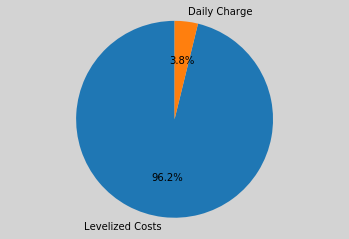

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[116.6866679641773, 252.40421113286544, 190.19079144234263, 52.9769392970219, 15.670805473859241, 2.9934459274807788, 0.5793199258722336, 0.7069379884749725, 0.3356427070750201, 3476.39, 336.6161, 0.0, 258.267, 78.3491, {'Levelized Costs': 3343.33, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60195719794, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.74545391196568, 147.51850171831603, 100.90889174209877, 31.410060415318103, 20.23811871990904, 22.278848768537053, 0.46448630048603046, 0.5909932663199755, 0.4838557124981845)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 31.4
                                           and a gcr of 0.464


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.201724052429199 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 20.2
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.858327627182007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 22.3
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8701729774475098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 145 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 308.026, 0.0]


ERROR:ga_logger:Cost: 3192.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,192 per year


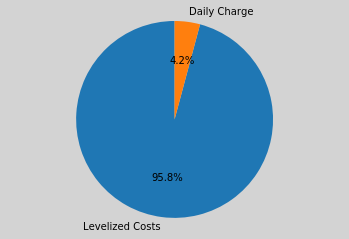

Total roof area of the  building: 599 m2
Total roof area used 521 m2
Percentage: 87.0%
succes
[[135.74545391196568, 147.51850171831603, 100.90889174209877, 31.410060415318103, 20.23811871990904, 22.278848768537053, 0.46448630048603046, 0.5909932663199755, 0.4838557124981845, 3192.43, 308.026, 0.0, 308.026, 0.0, {'Levelized Costs': 3059.382, 'Energy Charge': 0.006000000000028649, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60009810211, 61845.7, 521.2]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (177.31659342646498, 152.7229284379759, 209.07722792482286, 16.03519177562274, 38.64536124565569, 19.88939298670193, 0.3130876205696643, 0.42480116741215346, 0.22889230866940186)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 16.0
                                           and a gcr of 0.313


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9067258834838867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 153
                                           a tilt of 38.6
                                           and a gcr of 0.425


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8716235160827637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 209
                                           a tilt of 19.9
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.960226535797119 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 254.355, 0.0]


ERROR:ga_logger:Cost: 3885.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0198 /kWh
Total Cost of the system: $ 3,885 per year


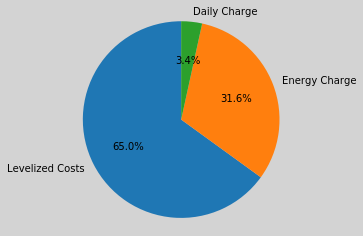

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[177.31659342646498, 152.7229284379759, 209.07722792482286, 16.03519177562274, 38.64536124565569, 19.88939298670193, 0.3130876205696643, 0.42480116741215346, 0.22889230866940186, 3885.46, 254.355, 0.0, 254.355, 0.0, {'Levelized Costs': 2526.304, 'Energy Charge': 1226.114, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 52060.295853987096, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.0482339174564, 143.67134853360446, 222.8386099348993, 55.64160208405453, 49.082561584740844, 46.50561096475902, 0.48032984506645365, 0.2307481747812559, 0.8956089272928205)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 55.6
                                           and a gcr of 0.480


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9287800788879395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 49.1
                                           and a gcr of 0.231


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.887040138244629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 46.5
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8963418006896973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 154s


ERROR:ga_logger:panel relevance: [221.445, 0.0, 123.357]


ERROR:ga_logger:Cost: 3557.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,558 per year


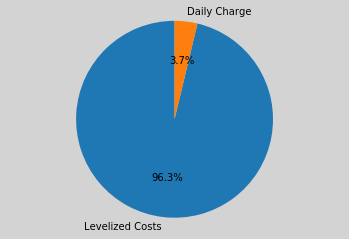

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[152.0482339174564, 143.67134853360446, 222.8386099348993, 55.64160208405453, 49.082561584740844, 46.50561096475902, 0.48032984506645365, 0.2307481747812559, 0.8956089272928205, 3557.7, 344.802, 221.445, 0.0, 123.357, {'Levelized Costs': 3424.644, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60429635001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.16464812249046, 258.1463712546972, 241.36753385716275, 9.284540869237237, 20.552791910462783, 10.844658216369536, 0.8536228903939878, 0.2030610748448922, 0.2993315809558154)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 254
                                           a tilt of 9.3
                                           and a gcr of 0.854


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.336081027984619 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 20.6
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4760665893554688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 10.8
                                           and a gcr of 0.299


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2190158367156982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 206 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [242.047, 0.0, 94.3519]


ERROR:ga_logger:Cost: 3474.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,474 per year


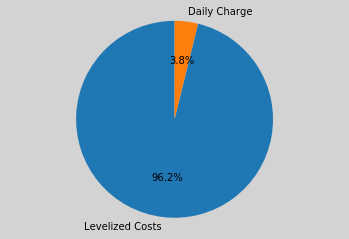

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[254.16464812249046, 258.1463712546972, 241.36753385716275, 9.284540869237237, 20.552791910462783, 10.844658216369536, 0.8536228903939878, 0.2030610748448922, 0.2993315809558154, 3474.24, 336.3989, 242.047, 0.0, 94.3519, {'Levelized Costs': 3341.191, 'Energy Charge': 0.007000000000061846, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59950985112, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.78743226562275, 156.83063894371028, 206.3221617681675, 13.395523988169826, 15.330977309148636, 1.3775784173298613, 0.3569693462056417, 0.7196644746343999, 0.7786276205194427)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 13.4
                                           and a gcr of 0.357


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.948284149169922 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 15.3
                                           and a gcr of 0.720


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.920900583267212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 1.4
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.377397060394287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 193 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 311.783, 0.0]


ERROR:ga_logger:Cost: 3229.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,230 per year


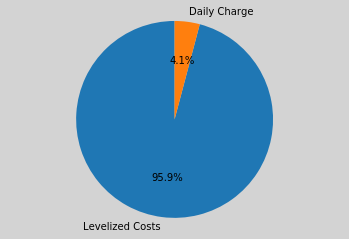

Total roof area of the  building: 599 m2
Total roof area used 433 m2
Percentage: 72.4%
succes
[[134.78743226562275, 156.83063894371028, 206.3221617681675, 13.395523988169826, 15.330977309148636, 1.3775784173298613, 0.3569693462056417, 0.7196644746343999, 0.7786276205194427, 3229.75, 311.783, 0.0, 311.783, 0.0, {'Levelized Costs': 3096.6910000000003, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60176078464, 61845.7, 433.234]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.03155280670038, 92.85446842799433, 240.85547721934145, 22.638184316706663, 53.04608282599308, 50.46991835705603, 0.48228451705654735, 0.83413636843642, 0.32737115283877216)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 22.6
                                           and a gcr of 0.482


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0480923652648926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 93
                                           a tilt of 53.0
                                           and a gcr of 0.834


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8603365421295166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 50.5
                                           and a gcr of 0.327


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8675649166107178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [288.773, 0.0, 0.0]


ERROR:ga_logger:Cost: 4072.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0173 /kWh
Total Cost of the system: $ 4,073 per year


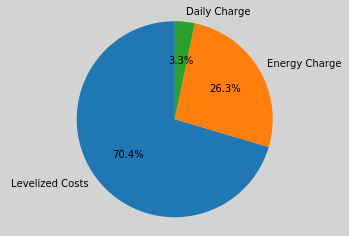

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[105.03155280670038, 92.85446842799433, 240.85547721934145, 22.638184316706663, 53.04608282599308, 50.46991835705603, 0.48228451705654735, 0.83413636843642, 0.32737115283877216, 4072.68, 288.773, 288.773, 0.0, 0.0, {'Levelized Costs': 2868.1499999999996, 'Energy Charge': 1071.4880000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53294.379604999755, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (189.06678978546654, 117.45503711575863, 138.35050217500023, 53.232876051000865, 55.13996836954313, 18.56374466799626, 0.39705726442947775, 0.332664517734525, 0.5354827137648406)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 53.2
                                           and a gcr of 0.397


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1518325805664062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 117
                                           a tilt of 55.1
                                           and a gcr of 0.333


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.892468214035034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 18.6
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9369797706604004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 154s


ERROR:ga_logger:panel relevance: [28.0787, 0.0, 282.759]


ERROR:ga_logger:Cost: 3220.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,220 per year


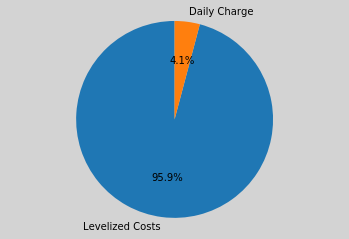

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[189.06678978546654, 117.45503711575863, 138.35050217500023, 53.232876051000865, 55.13996836954313, 18.56374466799626, 0.39705726442947775, 0.332664517734525, 0.5354827137648406, 3220.36, 310.83770000000004, 28.0787, 0.0, 282.759, {'Levelized Costs': 3087.302, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599733985124, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (150.405034107817, 264.17615023156304, 105.12065965512464, 29.926465542793284, 12.854006968378327, 34.70032118489179, 0.4700384097058209, 0.36175037968241436, 0.7025127516548282)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 29.9
                                           and a gcr of 0.470


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.297105550765991 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 12.9
                                           and a gcr of 0.362


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9242804050445557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 34.7
                                           and a gcr of 0.703


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.896981954574585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [180.57, 0.0, 150.761]


ERROR:ga_logger:Cost: 3423.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,424 per year


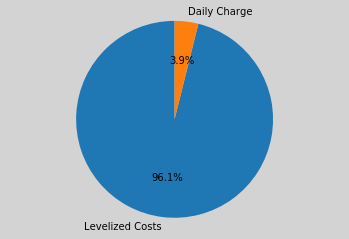

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[150.405034107817, 264.17615023156304, 105.12065965512464, 29.926465542793284, 12.854006968378327, 34.70032118489179, 0.4700384097058209, 0.36175037968241436, 0.7025127516548282, 3423.9, 331.331, 180.57, 0.0, 150.761, {'Levelized Costs': 3290.8540000000003, 'Energy Charge': 0.003999999999848569, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601061870046, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (167.58483514237366, 154.29931906522813, 151.19407762582935, 18.4832550342809, 22.951499208520723, 26.592763104843513, 0.5557756906850484, 0.5987148417412145, 0.7178565068106155)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 18.5
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9429690837860107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 23.0
                                           and a gcr of 0.599


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8992109298706055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 26.6
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.902010917663574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 172 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [302.435, 0.0, 0.0]


ERROR:ga_logger:Cost: 3136.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


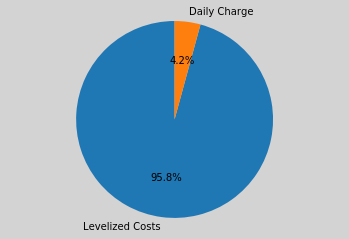

Total roof area of the  building: 599 m2
Total roof area used 544 m2
Percentage: 90.9%
succes
[[167.58483514237366, 154.29931906522813, 151.19407762582935, 18.4832550342809, 22.951499208520723, 26.592763104843513, 0.5557756906850484, 0.5987148417412145, 0.7178565068106155, 3136.9, 302.435, 302.435, 0.0, 0.0, {'Levelized Costs': 3003.842, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59994749008, 61845.7, 544.167]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (251.1008093722075, 136.86205988601202, 124.3902748089076, 15.86194173385408, 53.53172353100486, 44.75218466964415, 0.6871425904847429, 0.7830001999834495, 0.7818253849260408)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 15.9
                                           and a gcr of 0.687


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9895927906036377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 53.5
                                           and a gcr of 0.783


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8597264289855957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 44.8
                                           and a gcr of 0.782


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.884145736694336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 185 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [337.526, 0.0, 0.0]


ERROR:ga_logger:Cost: 3485.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,485 per year


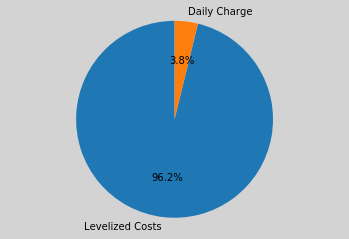

Total roof area of the  building: 599 m2
Total roof area used 491 m2
Percentage: 82.0%
succes
[[251.1008093722075, 136.86205988601202, 124.3902748089076, 15.86194173385408, 53.53172353100486, 44.75218466964415, 0.6871425904847429, 0.7830001999834495, 0.7818253849260408, 3485.43, 337.526, 337.526, 0.0, 0.0, {'Levelized Costs': 3352.386, 'Energy Charge': 0.00200000000018008, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600637280804, 61845.7, 491.202]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.46328333889483, 105.45929429125401, 184.5480080083182, 9.224545466833241, 14.903246980689783, 22.591832388518796, 0.22967956736329923, 0.3711875973949095, 0.4700872786283407)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 9.2
                                           and a gcr of 0.230


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1427879333496094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 14.9
                                           and a gcr of 0.371


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.876544952392578 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 22.6
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9698550701141357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 281.47]


ERROR:ga_logger:Cost: 3326.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0064 /kWh
Total Cost of the system: $ 3,327 per year


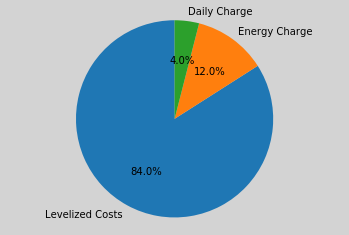

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.46328333889483, 105.45929429125401, 184.5480080083182, 9.224545466833241, 14.903246980689783, 22.591832388518796, 0.22967956736329923, 0.3711875973949095, 0.4700872786283407, 3326.89, 281.47, 0.0, 0.0, 281.47, {'Levelized Costs': 2795.622, 'Energy Charge': 398.2260000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58667.52628534422, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.12176920007767, 132.88749383159308, 93.23543447306672, 33.4321212622666, 41.49125457584123, 8.006885654835706, 0.5699825678871853, 0.6510034732621083, 0.6897827728129371)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 33.4
                                           and a gcr of 0.570


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9368600845336914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 41.5
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.84466814994812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 8.0
                                           and a gcr of 0.690


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8305342197418213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 336.493]


ERROR:ga_logger:Cost: 3475.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,475 per year


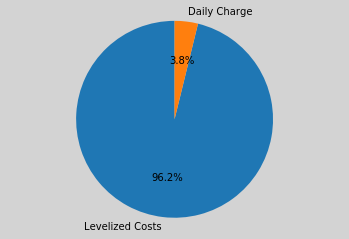

Total roof area of the  building: 599 m2
Total roof area used 488 m2
Percentage: 81.5%
succes
[[264.12176920007767, 132.88749383159308, 93.23543447306672, 33.4321212622666, 41.49125457584123, 8.006885654835706, 0.5699825678871853, 0.6510034732621083, 0.6897827728129371, 3475.17, 336.493, 0.0, 0.0, 336.493, {'Levelized Costs': 3342.1200000000003, 'Energy Charge': 0.007999999999924512, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602755549786, 61845.7, 487.824]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.4918516922067, 160.9398814042558, 227.7305166833323, 24.510793598750574, 25.096462549017446, 38.62236718680195, 0.3308604694536681, 0.3576408981578638, 0.5102967693690814)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 24.5
                                           and a gcr of 0.331


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9444425106048584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 161
                                           a tilt of 25.1
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9162392616271973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 228
                                           a tilt of 38.6
                                           and a gcr of 0.510


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9163687229156494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 116s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.546]


ERROR:ga_logger:Cost: 3662.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0080 /kWh
Total Cost of the system: $ 3,663 per year


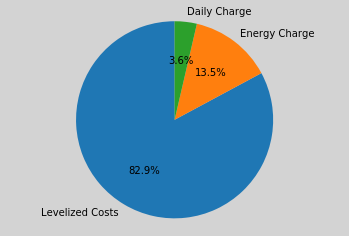

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[201.4918516922067, 160.9398814042558, 227.7305166833323, 24.510793598750574, 25.096462549017446, 38.62236718680195, 0.3308604694536681, 0.3576408981578638, 0.5102967693690814, 3662.91, 305.546, 0.0, 0.0, 305.546, {'Levelized Costs': 3034.7400000000002, 'Energy Charge': 495.12799999999993, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57894.19761001893, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.91103146237438, 111.73879479681835, 134.03767855386695, 27.962658786898803, 29.741293516417834, 7.639527116983019, 0.4547269737343429, 0.23796381230831276, 0.5468631639595669)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 28.0
                                           and a gcr of 0.455


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9953479766845703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 29.7
                                           and a gcr of 0.238


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9238014221191406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 134
                                           a tilt of 7.6
                                           and a gcr of 0.547


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8874385356903076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [33.1663, 0.0, 287.554]


ERROR:ga_logger:Cost: 3318.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


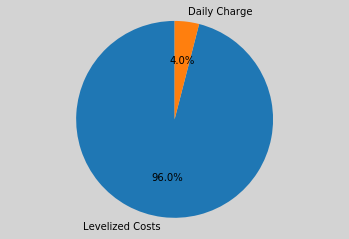

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[223.91103146237438, 111.73879479681835, 134.03767855386695, 27.962658786898803, 29.741293516417834, 7.639527116983019, 0.4547269737343429, 0.23796381230831276, 0.5468631639595669, 3318.52, 320.72029999999995, 33.1663, 0.0, 287.554, {'Levelized Costs': 3185.466, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601305888435, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (256.8556626036917, 142.26145093412686, 184.2287218073248, 21.17203883684312, 52.385767772429304, 54.62141765180608, 0.5738304554707877, 0.6833336629808778, 0.25265313514284826)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 21.2
                                           and a gcr of 0.574


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6648409366607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 142
                                           a tilt of 52.4
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.98783278465271 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 54.6
                                           and a gcr of 0.253


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.021251678466797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 262s


ERROR:ga_logger:panel relevance: [342.926, 0.788097, 0.0]


ERROR:ga_logger:Cost: 3546.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,547 per year


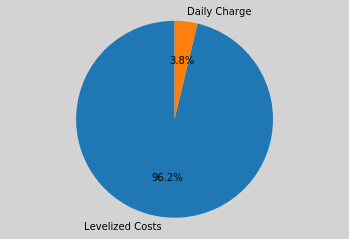

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[256.8556626036917, 142.26145093412686, 184.2287218073248, 21.17203883684312, 52.385767772429304, 54.62141765180608, 0.5738304554707877, 0.6833336629808778, 0.25265313514284826, 3546.89, 343.714097, 342.926, 0.788097, 0.0, {'Levelized Costs': 3413.836, 'Energy Charge': 0.012000000000398359, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60336542454, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (222.85470144397456, 253.14318803725308, 146.2945678728547, 24.013899603154098, 1.1932042627357449, 8.484508679488385, 0.6045736104041763, 0.8042528337217045, 0.8673763484323456)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 24.0
                                           and a gcr of 0.605


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1603527069091797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 1.2
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.73110032081604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 8.5
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.900869369506836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  81 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 153 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [316.34, 0.0, 0.0]


ERROR:ga_logger:Cost: 3275.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,275 per year


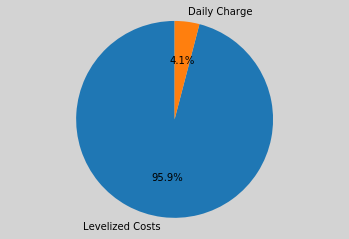

Total roof area of the  building: 599 m2
Total roof area used 523 m2
Percentage: 87.4%
succes
[[222.85470144397456, 253.14318803725308, 146.2945678728547, 24.013899603154098, 1.1932042627357449, 8.484508679488385, 0.6045736104041763, 0.8042528337217045, 0.8673763484323456, 3275.01, 316.34, 316.34, 0.0, 0.0, {'Levelized Costs': 3141.951, 'Energy Charge': 0.017000000000336968, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60081723602, 61845.7, 523.245]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.75011537974785, 95.48577214292297, 152.56557459896794, 55.891696028815986, 14.386720458768398, 36.9859122742099, 0.6629002454985038, 0.21052119710598283, 0.4889218494310878)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 55.9
                                           and a gcr of 0.663


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3628172874450684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 14.4
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.916055679321289 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 37.0
                                           and a gcr of 0.489


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1225011348724365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 156 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 144s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 292.748]


ERROR:ga_logger:Cost: 3337.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0048 /kWh
Total Cost of the system: $ 3,338 per year


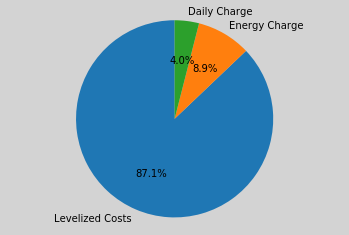

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[261.75011537974785, 95.48577214292297, 152.56557459896794, 55.891696028815986, 14.386720458768398, 36.9859122742099, 0.6629002454985038, 0.21052119710598283, 0.4889218494310878, 3337.97, 292.748, 0.0, 0.0, 292.748, {'Levelized Costs': 2907.6319999999996, 'Energy Charge': 297.29600000000016, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59473.05260761505, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.65540806346283, 245.78992406745203, 163.34376783551693, 37.205314178703276, 38.59066607505807, 12.855268687860484, 0.7961483539833003, 0.6122027118573065, 0.8537168809001989)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 37.2
                                           and a gcr of 0.796


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.094431161880493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 38.6
                                           and a gcr of 0.612


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.119486093521118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 12.9
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.865703821182251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 166s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.877]


ERROR:ga_logger:Cost: 3300.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


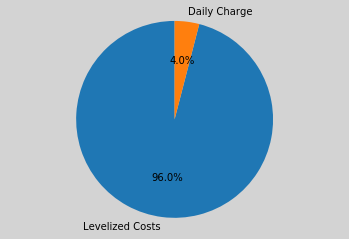

Total roof area of the  building: 599 m2
Total roof area used 374 m2
Percentage: 62.4%
succes
[[126.65540806346283, 245.78992406745203, 163.34376783551693, 37.205314178703276, 38.59066607505807, 12.855268687860484, 0.7961483539833003, 0.6122027118573065, 0.8537168809001989, 3300.21, 318.877, 0.0, 0.0, 318.877, {'Levelized Costs': 3167.145, 'Energy Charge': 0.02299999999991087, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601863160155, 61845.7, 373.517]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (222.74355895123173, 90.01956943314565, 148.1572863480997, 55.84652118878282, 41.67194202012076, 4.9464977834585415, 0.8105187700779366, 0.7470429052281229, 0.6435068468466338)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 223
                                           a tilt of 55.8
                                           and a gcr of 0.811


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.094672203063965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 41.7
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.531301736831665 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 148
                                           a tilt of 4.9
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.916625499725342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  82 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 324.331]


ERROR:ga_logger:Cost: 3354.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,354 per year


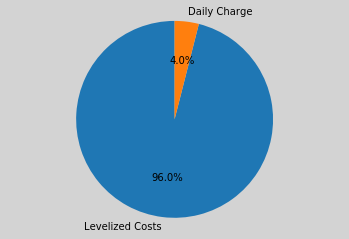

Total roof area of the  building: 599 m2
Total roof area used 504 m2
Percentage: 84.2%
succes
[[222.74355895123173, 90.01956943314565, 148.1572863480997, 55.84652118878282, 41.67194202012076, 4.9464977834585415, 0.8105187700779366, 0.7470429052281229, 0.6435068468466338, 3354.38, 324.331, 0.0, 0.0, 324.331, {'Levelized Costs': 3221.3250000000003, 'Energy Charge': 0.012999999999806278, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60007612995, 61845.7, 504.005]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.83677578711809, 164.50178022435125, 234.06743455904362, 29.04288943277538, 31.33269401215366, 17.820564445381798, 0.7660694913412645, 0.6523496721111262, 0.7403998313077904)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 29.0
                                           and a gcr of 0.766


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.484029769897461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 31.3
                                           and a gcr of 0.652


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9556241035461426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 17.8
                                           and a gcr of 0.740


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9827144145965576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 227 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 305.484, 0.0]


ERROR:ga_logger:Cost: 3167.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,167 per year


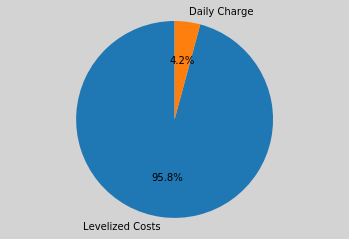

Total roof area of the  building: 599 m2
Total roof area used 468 m2
Percentage: 78.2%
succes
[[166.83677578711809, 164.50178022435125, 234.06743455904362, 29.04288943277538, 31.33269401215366, 17.820564445381798, 0.7660694913412645, 0.6523496721111262, 0.7403998313077904, 3167.18, 305.484, 0.0, 305.484, 0.0, {'Levelized Costs': 3034.1209999999996, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59877370011, 61845.7, 468.283]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (123.95827079119923, 246.4495823985335, 189.7486075206412, 43.78158730957785, 47.319368666257475, 26.680976363061863, 0.3625440604213482, 0.5977757670254701, 0.40397788938431056)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 43.8
                                           and a gcr of 0.363


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.891885280609131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 47.3
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4731152057647705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 26.7
                                           and a gcr of 0.404


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9595625400543213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 241.886]


ERROR:ga_logger:Cost: 3921.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0224 /kWh
Total Cost of the system: $ 3,922 per year


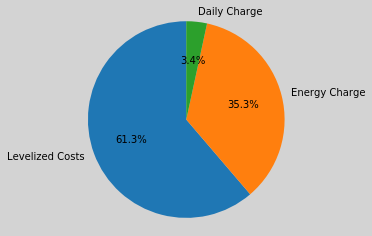

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[123.95827079119923, 246.4495823985335, 189.7486075206412, 43.78158730957785, 47.319368666257475, 26.680976363061863, 0.3625440604213482, 0.5977757670254701, 0.40397788938431056, 3921.54, 241.886, 0.0, 0.0, 241.886, {'Levelized Costs': 2402.4610000000002, 'Energy Charge': 1386.0369999999998, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 50783.97487512341, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (207.34756003822213, 171.48045648258872, 176.48357620192485, 28.161863724249205, 48.479868417529524, 35.73158551585838, 0.3787622204019462, 0.7533618289385253, 0.5595920331604829)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 207
                                           a tilt of 28.2
                                           and a gcr of 0.379


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.131556272506714 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 48.5
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.985797643661499 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 35.7
                                           and a gcr of 0.560


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.915713310241699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.156]


ERROR:ga_logger:Cost: 3104.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,104 per year


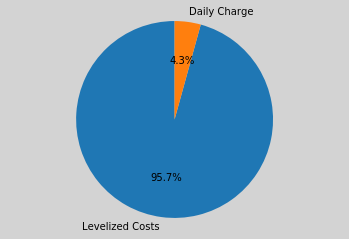

Total roof area of the  building: 599 m2
Total roof area used 535 m2
Percentage: 89.3%
succes
[[207.34756003822213, 171.48045648258872, 176.48357620192485, 28.161863724249205, 48.479868417529524, 35.73158551585838, 0.3787622204019462, 0.7533618289385253, 0.5595920331604829, 3104.34, 299.156, 0.0, 0.0, 299.156, {'Levelized Costs': 2971.2850000000003, 'Energy Charge': 0.012999999999863121, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59841235017, 61845.7, 534.597]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.75897239990417, 113.58856248538545, 158.6171370987547, 15.529558353497015, 53.8733214494554, 3.6349223954646313, 0.5714933265840343, 0.6232418075210198, 0.7534867640009024)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 15.5
                                           and a gcr of 0.571


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4003257751464844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 53.9
                                           and a gcr of 0.623


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9050135612487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 3.6
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8535444736480713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 192s


ERROR:ga_logger:panel relevance: [308.231, 0.0, 0.0]


ERROR:ga_logger:Cost: 3194.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,194 per year


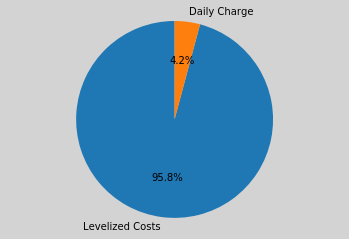

Total roof area of the  building: 599 m2
Total roof area used 539 m2
Percentage: 90.1%
succes
[[152.75897239990417, 113.58856248538545, 158.6171370987547, 15.529558353497015, 53.8733214494554, 3.6349223954646313, 0.5714933265840343, 0.6232418075210198, 0.7534867640009024, 3194.47, 308.231, 308.231, 0.0, 0.0, {'Levelized Costs': 3061.4219999999996, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601694199715, 61845.7, 539.344]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.00038749164298, 187.88401172617893, 242.96331969496723, 15.28967867756648, 39.592814856831154, 44.75816045059717, 0.3623861043763805, 0.8357474181223723, 0.5661394813589837)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 15.3
                                           and a gcr of 0.362


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.804988145828247 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 39.6
                                           and a gcr of 0.836


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.951962947845459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 243
                                           a tilt of 44.8
                                           and a gcr of 0.566


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1404223442077637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 320.81, 0.0]


ERROR:ga_logger:Cost: 3319.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


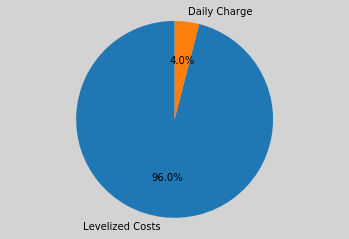

Total roof area of the  building: 599 m2
Total roof area used 384 m2
Percentage: 64.1%
succes
[[251.00038749164298, 187.88401172617893, 242.96331969496723, 15.28967867756648, 39.592814856831154, 44.75816045059717, 0.3623861043763805, 0.8357474181223723, 0.5661394813589837, 3319.41, 320.81, 0.0, 320.81, 0.0, {'Levelized Costs': 3186.3569999999995, 'Energy Charge': 0.011000000000251475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60108716344, 61845.7, 383.86]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.79021863931757, 226.68257406867252, 117.13082262650968, 54.98310352810582, 32.118587396415535, 44.817369868601816, 0.6282104055040683, 0.6949273922054962, 0.2184595767687495)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 55.0
                                           and a gcr of 0.628


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.310739517211914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 227
                                           a tilt of 32.1
                                           and a gcr of 0.695


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9988138675689697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 117
                                           a tilt of 44.8
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9097061157226562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 156s


ERROR:ga_logger:panel relevance: [0.0, 294.009, 38.3797]


ERROR:ga_logger:Cost: 3434.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,434 per year


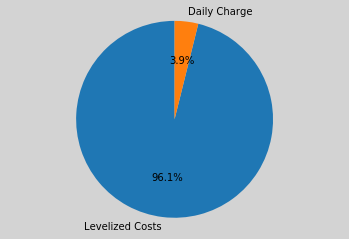

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.79021863931757, 226.68257406867252, 117.13082262650968, 54.98310352810582, 32.118587396415535, 44.817369868601816, 0.6282104055040683, 0.6949273922054962, 0.2184595767687495, 3434.41, 332.38870000000003, 0.0, 294.009, 38.3797, {'Levelized Costs': 3301.353, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59973033004, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (231.77084031083234, 104.8261625159415, 190.27856439054239, 13.335515485465468, 35.24092617009368, 1.45117494247071, 0.5960367557496922, 0.32539417544992677, 0.7616331012209201)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 13.3
                                           and a gcr of 0.596


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2603211402893066 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 35.2
                                           and a gcr of 0.325


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8987226486206055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 1.5
                                           and a gcr of 0.762


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.573202610015869 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [322.031, 0.0, 0.0]


ERROR:ga_logger:Cost: 3331.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,332 per year


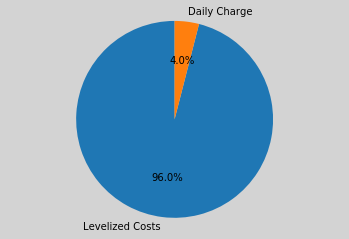

Total roof area of the  building: 599 m2
Total roof area used 540 m2
Percentage: 90.2%
succes
[[231.77084031083234, 104.8261625159415, 190.27856439054239, 13.335515485465468, 35.24092617009368, 1.45117494247071, 0.5960367557496922, 0.32539417544992677, 0.7616331012209201, 3331.53, 322.031, 322.031, 0.0, 0.0, {'Levelized Costs': 3198.478, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60024397142, 61845.7, 540.287]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.92398438401892, 259.01799168841114, 248.04908363046837, 51.020475124311844, 18.142922558056327, 32.70902602046958, 0.769495483557465, 0.8706754848118492, 0.8265291562707104)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 51.0
                                           and a gcr of 0.769


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5910561084747314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 18.1
                                           and a gcr of 0.871


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9500417709350586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 32.7
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8639373779296875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 229s


ERROR:ga_logger:panel relevance: [340.347, 0.0, 0.0]


ERROR:ga_logger:Cost: 3513.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,513 per year


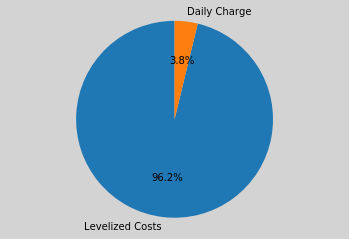

Total roof area of the  building: 599 m2
Total roof area used 442 m2
Percentage: 73.9%
succes
[[159.92398438401892, 259.01799168841114, 248.04908363046837, 51.020475124311844, 18.142922558056327, 32.70902602046958, 0.769495483557465, 0.8706754848118492, 0.8265291562707104, 3513.46, 340.347, 340.347, 0.0, 0.0, {'Levelized Costs': 3380.398, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60219840014, 61845.7, 442.299]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (97.61394436048376, 193.10759514303479, 260.023066326679, 36.09560947514998, 27.248937016460374, 5.54847853953807, 0.6044271691038658, 0.8483784061202468, 0.34626302640993634)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 98
                                           a tilt of 36.1
                                           and a gcr of 0.604


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0225167274475098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 27.2
                                           and a gcr of 0.848


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8750548362731934 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 5.5
                                           and a gcr of 0.346


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.859985113143921 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


--- Logging error ---
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 996, in emit
    self.flush()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 976, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:


  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/asyncio/base_events.py", l

ERROR:ga_logger:panel relevance: [0.0, 317.499, 0.0]


ERROR:ga_logger:Cost: 3286.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,287 per year


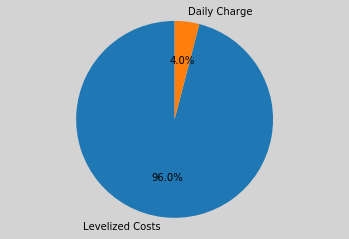

Total roof area of the  building: 599 m2
Total roof area used 374 m2
Percentage: 62.5%
succes
[[97.61394436048376, 193.10759514303479, 260.023066326679, 36.09560947514998, 27.248937016460374, 5.54847853953807, 0.6044271691038658, 0.8483784061202468, 0.34626302640993634, 3286.52, 317.499, 0.0, 317.499, 0.0, {'Levelized Costs': 3153.4689999999996, 'Energy Charge': 0.0090000000004693, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6022727653, 61845.7, 374.242]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (262.0142912390429, 229.5670341384229, 235.12219388568332, 4.085376639783708, 40.401554029069366, 17.515039735598084, 0.7845447919723698, 0.39312491842449593, 0.30675916205667714)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 4.1
                                           and a gcr of 0.785


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.059795618057251 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 40.4
                                           and a gcr of 0.393


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8859071731567383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 17.5
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8853600025177 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [191.481, 139.44, 0.0]


ERROR:ga_logger:Cost: 3419.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,420 per year


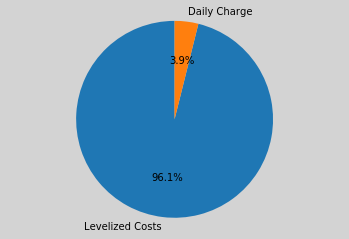

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[262.0142912390429, 229.5670341384229, 235.12219388568332, 4.085376639783708, 40.401554029069366, 17.515039735598084, 0.7845447919723698, 0.39312491842449593, 0.30675916205667714, 3419.82, 330.921, 191.481, 139.44, 0.0, {'Levelized Costs': 3286.77, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60284463922, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (206.222660525177, 153.8751818144974, 176.1192039875902, 30.11560105256136, 41.841192677991984, 32.5688427145851, 0.8475093976106667, 0.7670561752274865, 0.8395611153651497)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 206
                                           a tilt of 30.1
                                           and a gcr of 0.848


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0580759048461914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 41.8
                                           and a gcr of 0.767


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8936376571655273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 32.6
                                           and a gcr of 0.840


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8829872608184814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 141 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.6]


ERROR:ga_logger:Cost: 3277.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


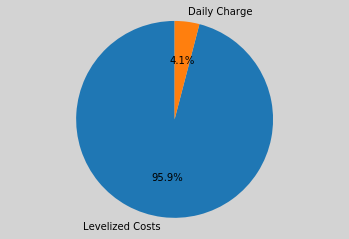

Total roof area of the  building: 599 m2
Total roof area used 377 m2
Percentage: 63.0%
succes
[[206.222660525177, 153.8751818144974, 176.1192039875902, 30.11560105256136, 41.841192677991984, 32.5688427145851, 0.8475093976106667, 0.7670561752274865, 0.8395611153651497, 3277.6, 316.6, 0.0, 0.0, 316.6, {'Levelized Costs': 3144.551, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60056525526, 61845.7, 377.102]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.0647166007792, 254.04044047794054, 191.93203580625618, 30.624498534807127, 45.43699418175455, 55.36795134611593, 0.2696893254823517, 0.7400543954419314, 0.35586233635818876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 30.6
                                           and a gcr of 0.270


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.334780216217041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 254
                                           a tilt of 45.4
                                           and a gcr of 0.740


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.911163330078125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 55.4
                                           and a gcr of 0.356


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.900183916091919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 154s


ERROR:ga_logger:panel relevance: [0.0, 364.871, 37.6249]


ERROR:ga_logger:Cost: 4130.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,131 per year


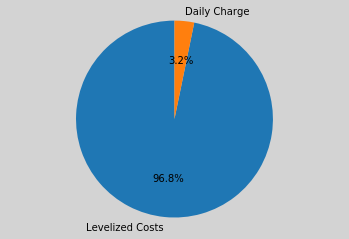

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[258.0647166007792, 254.04044047794054, 191.93203580625618, 30.624498534807127, 45.43699418175455, 55.36795134611593, 0.2696893254823517, 0.7400543954419314, 0.35586233635818876, 4130.73, 402.4959, 0.0, 364.871, 37.6249, {'Levelized Costs': 3997.6729999999993, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60315798015, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (224.81660539851748, 95.7500018326187, 161.53902132763608, 2.4292324376148233, 9.271689205666334, 7.077343482698908, 0.32403784553491455, 0.715808739748401, 0.5780569363428456)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 2.4
                                           and a gcr of 0.324


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.83970308303833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 9.3
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.837177276611328 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 7.1
                                           and a gcr of 0.578


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8712267875671387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.559]


ERROR:ga_logger:Cost: 3297.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,297 per year


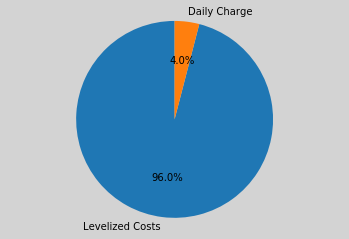

Total roof area of the  building: 599 m2
Total roof area used 551 m2
Percentage: 92.0%
succes
[[224.81660539851748, 95.7500018326187, 161.53902132763608, 2.4292324376148233, 9.271689205666334, 7.077343482698908, 0.32403784553491455, 0.715808739748401, 0.5780569363428456, 3297.05, 318.559, 0.0, 0.0, 318.559, {'Levelized Costs': 3163.994, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60162660596, 61845.7, 551.086]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (194.27803343951064, 119.13147398424923, 126.73502845275641, 55.00844835159539, 2.111332202798223, 23.35541082367239, 0.8069041297440389, 0.6899157924244126, 0.42583770292470946)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 194
                                           a tilt of 55.0
                                           and a gcr of 0.807


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.148890733718872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 2.1
                                           and a gcr of 0.690


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.731708526611328 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 23.4
                                           and a gcr of 0.426


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8455324172973633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 263 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 181.004, 143.254]


ERROR:ga_logger:Cost: 3353.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,354 per year


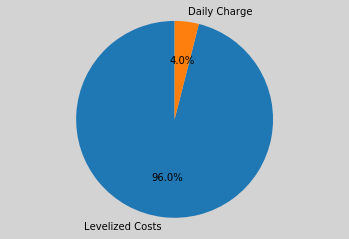

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[194.27803343951064, 119.13147398424923, 126.73502845275641, 55.00844835159539, 2.111332202798223, 23.35541082367239, 0.8069041297440389, 0.6899157924244126, 0.42583770292470946, 3353.65, 324.258, 0.0, 181.004, 143.254, {'Levelized Costs': 3220.588, 'Energy Charge': 0.019999999999868123, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60078275001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (183.04938842004015, 154.9936480470802, 102.76902961836477, 39.87842221100488, 9.049509397763321, 16.50798910691372, 0.8506483666246798, 0.3119471034331639, 0.7430839376387393)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 183
                                           a tilt of 39.9
                                           and a gcr of 0.851


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2205212116241455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 9.0
                                           and a gcr of 0.312


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8464572429656982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 103
                                           a tilt of 16.5
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8395161628723145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [207.356, 110.741, 0.0]


ERROR:ga_logger:Cost: 3292.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,292 per year


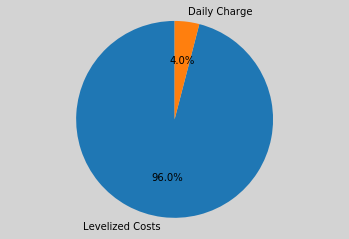

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[183.04938842004015, 154.9936480470802, 102.76902961836477, 39.87842221100488, 9.049509397763321, 16.50798910691372, 0.8506483666246798, 0.3119471034331639, 0.7430839376387393, 3292.46, 318.097, 207.356, 110.741, 0.0, {'Levelized Costs': 3159.408, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60244240891, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (92.98624603272538, 218.51617194175284, 233.26606154821135, 28.23657584776215, 10.90413795937694, 20.811875890192695, 0.2103039541535544, 0.3181856327369443, 0.8083218888596608)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 28.2
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.222245454788208 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 10.9
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1225028038024902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 20.8
                                           and a gcr of 0.808


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8627865314483643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 140s


ERROR:ga_logger:panel relevance: [0.0, 99.3438, 231.618]


ERROR:ga_logger:Cost: 3420.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,420 per year


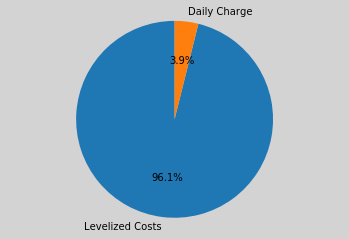

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[92.98624603272538, 218.51617194175284, 233.26606154821135, 28.23657584776215, 10.90413795937694, 20.811875890192695, 0.2103039541535544, 0.3181856327369443, 0.8083218888596608, 3420.24, 330.9618, 0.0, 99.3438, 231.618, {'Levelized Costs': 3287.1929999999998, 'Energy Charge': 0.0049999999999954525, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602512877595, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (260.031911919854, 124.55025632668318, 234.0007768686031, 23.844192567673524, 21.804133798040375, 10.032506019145105, 0.37518851595401104, 0.3413237806039326, 0.5389228291586117)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 23.8
                                           and a gcr of 0.375


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.089667558670044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 21.8
                                           and a gcr of 0.341


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9185121059417725 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 10.0
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.885895013809204 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 125s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 322.686]


ERROR:ga_logger:Cost: 3377.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0006 /kWh
Total Cost of the system: $ 3,378 per year


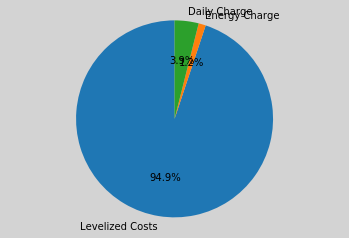

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[260.031911919854, 124.55025632668318, 234.0007768686031, 23.844192567673524, 21.804133798040375, 10.032506019145105, 0.37518851595401104, 0.3413237806039326, 0.5389228291586117, 3377.87, 322.686, 0.0, 0.0, 322.686, {'Levelized Costs': 3204.987, 'Energy Charge': 39.840999999999894, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61527.72211142446, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (164.7558763479144, 162.88827041775556, 169.65884319096807, 21.129245896685603, 22.053809916657414, 33.8741548539788, 0.7930582555125929, 0.5398132193193741, 0.45573889949143026)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 21.1
                                           and a gcr of 0.793


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.017043352127075 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 22.1
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.930495500564575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 33.9
                                           and a gcr of 0.456


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9612457752227783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 156s


ERROR:ga_logger:panel relevance: [0.0, 162.476, 135.709]


ERROR:ga_logger:Cost: 3094.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,095 per year


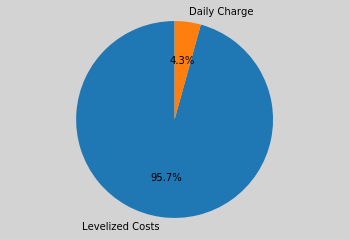

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[164.7558763479144, 162.88827041775556, 169.65884319096807, 21.129245896685603, 22.053809916657414, 33.8741548539788, 0.7930582555125929, 0.5398132193193741, 0.45573889949143026, 3094.68, 298.185, 0.0, 162.476, 135.709, {'Levelized Costs': 2961.6209999999996, 'Energy Charge': 0.01700000000039381, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60091169997, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.4610854836639, 200.7625439709241, 244.32022193676025, 40.93602776359591, 40.56447038084324, 10.380262105297163, 0.40825548644864906, 0.49311712241616695, 0.38256008111162254)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 40.9
                                           and a gcr of 0.408


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.967136859893799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 40.6
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.848598003387451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 244
                                           a tilt of 10.4
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.880250930786133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  79 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 295.26, 0.0]


ERROR:ga_logger:Cost: 3303.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0038 /kWh
Total Cost of the system: $ 3,303 per year


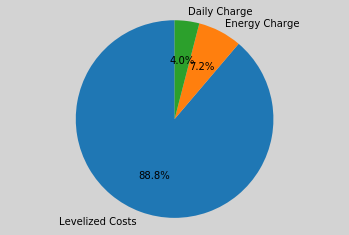

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[170.4610854836639, 200.7625439709241, 244.32022193676025, 40.93602776359591, 40.56447038084324, 10.380262105297163, 0.40825548644864906, 0.49311712241616695, 0.38256008111162254, 3303.26, 295.26, 0.0, 295.26, 0.0, {'Levelized Costs': 2932.579, 'Energy Charge': 237.63900000000024, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59949.15679719481, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.61820681532618, 144.54084046700984, 131.20885131988777, 16.801133401773022, 32.85851553529613, 47.13283171021635, 0.7853120794985371, 0.4658324477377129, 0.4648247179265006)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 16.8
                                           and a gcr of 0.785


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7797844409942627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 32.9
                                           and a gcr of 0.466


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.918684244155884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 47.1
                                           and a gcr of 0.465


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.902254343032837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 144s


ERROR:ga_logger:panel relevance: [68.7611, 238.135, 0.0]


ERROR:ga_logger:Cost: 3181.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,181 per year


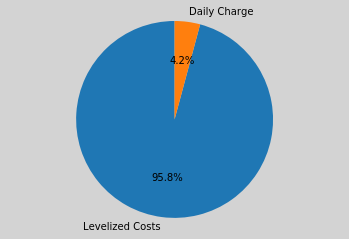

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[174.61820681532618, 144.54084046700984, 131.20885131988777, 16.801133401773022, 32.85851553529613, 47.13283171021635, 0.7853120794985371, 0.4658324477377129, 0.4648247179265006, 3181.21, 306.8961, 68.7611, 238.135, 0.0, {'Levelized Costs': 3048.143, 'Energy Charge': 0.02500000000026148, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598084891986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.17885823344875, 238.0757990993623, 180.08318614016827, 2.654343823593841, 54.46852007949634, 52.641271548212885, 0.22903858879586167, 0.4234442808371518, 0.672078836396983)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 2.7
                                           and a gcr of 0.229


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8631975650787354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 54.5
                                           and a gcr of 0.423


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9514098167419434 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 52.6
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.023627996444702 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 144 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.552]


ERROR:ga_logger:Cost: 3316.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,317 per year


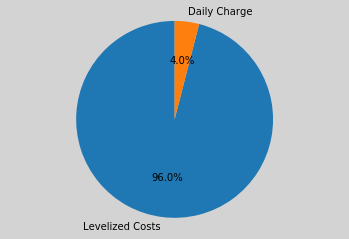

Total roof area of the  building: 599 m2
Total roof area used 477 m2
Percentage: 79.7%
succes
[[114.17885823344875, 238.0757990993623, 180.08318614016827, 2.654343823593841, 54.46852007949634, 52.641271548212885, 0.22903858879586167, 0.4234442808371518, 0.672078836396983, 3316.84, 320.552, 0.0, 0.0, 320.552, {'Levelized Costs': 3183.786, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602224903116, 61845.7, 476.956]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (217.1406323399044, 166.46761900557453, 184.8670037557398, 9.353695496453799, 11.549932662525142, 52.831989554742634, 0.31344115610552326, 0.45466461877400316, 0.769990511862175)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 217
                                           a tilt of 9.4
                                           and a gcr of 0.313


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.672208547592163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 11.5
                                           and a gcr of 0.455


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8919808864593506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 52.8
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9612128734588623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 319 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 208.759, 107.501]


ERROR:ga_logger:Cost: 3274.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,274 per year


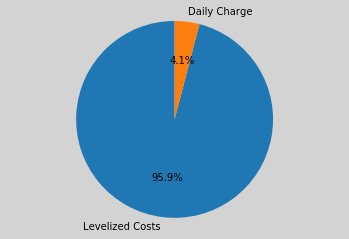

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[217.1406323399044, 166.46761900557453, 184.8670037557398, 9.353695496453799, 11.549932662525142, 52.831989554742634, 0.31344115610552326, 0.45466461877400316, 0.769990511862175, 3274.21, 316.26, 0.0, 208.759, 107.501, {'Levelized Costs': 3141.1530000000002, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603447112684, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (116.7586351194457, 236.22445818009655, 170.6012344370635, 31.94291518938182, 29.304925088227176, 34.54656211338414, 0.3511425229583849, 0.4082359261347469, 0.4264592878085386)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 31.9
                                           and a gcr of 0.351


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9232711791992188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 236
                                           a tilt of 29.3
                                           and a gcr of 0.408


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.907888412475586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 171
                                           a tilt of 34.5
                                           and a gcr of 0.426


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9066762924194336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


--- Logging error ---
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 996, in emit
    self.flush()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 976, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
  

ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 148s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 255.347]


ERROR:ga_logger:Cost: 3696.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0166 /kWh
Total Cost of the system: $ 3,697 per year


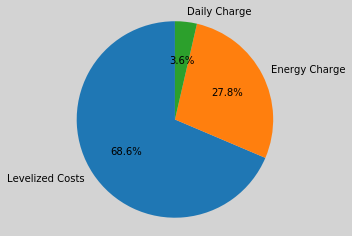

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[116.7586351194457, 236.22445818009655, 170.6012344370635, 31.94291518938182, 29.304925088227176, 34.54656211338414, 0.3511425229583849, 0.4082359261347469, 0.4264592878085386, 3696.64, 255.347, 0.0, 0.0, 255.347, {'Levelized Costs': 2536.158, 'Energy Charge': 1027.4400000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53645.87982052009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.76514750694298, 150.22940763609884, 123.62864458499507, 22.77221381391805, 30.97644584938166, 32.89976269361873, 0.6449982181638438, 0.6573059072926801, 0.46235989583927767)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 22.8
                                           and a gcr of 0.645


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9739952087402344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.657


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9249978065490723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 32.9
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1971144676208496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 131s


ERROR:ga_logger:panel relevance: [302.557, 0.0, 0.0]


ERROR:ga_logger:Cost: 3138.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,138 per year


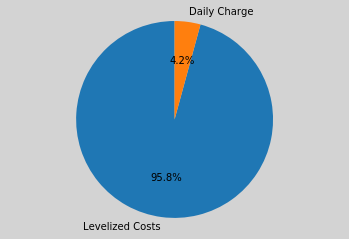

Total roof area of the  building: 599 m2
Total roof area used 469 m2
Percentage: 78.3%
succes
[[170.76514750694298, 150.22940763609884, 123.62864458499507, 22.77221381391805, 30.97644584938166, 32.89976269361873, 0.6449982181638438, 0.6573059072926801, 0.46235989583927767, 3138.12, 302.557, 302.557, 0.0, 0.0, {'Levelized Costs': 3005.0649999999996, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598511597585, 61845.7, 469.082]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (233.4325319194833, 96.78414376390268, 206.19638703309096, 36.929697753637285, 36.860717751718404, 6.755864377584649, 0.5578274631640767, 0.5177922693886403, 0.3297508325260634)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 36.9
                                           and a gcr of 0.558


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6665399074554443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 36.9
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8678646087646484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 6.8
                                           and a gcr of 0.330


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9072043895721436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [334.006, 0.0, 0.0]


ERROR:ga_logger:Cost: 3467.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0003 /kWh
Total Cost of the system: $ 3,468 per year


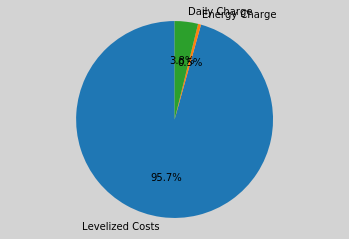

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[233.4325319194833, 96.78414376390268, 206.19638703309096, 36.929697753637285, 36.860717751718404, 6.755864377584649, 0.5578274631640767, 0.5177922693886403, 0.3297508325260634, 3467.59, 334.006, 334.006, 0.0, 0.0, {'Levelized Costs': 3317.4080000000004, 'Energy Charge': 17.139999999999986, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61708.92004359065, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.83138965254034, 91.26559145734917, 264.86403816696793, 21.24624250819528, 42.594073442478035, 29.23269621722401, 0.6363887783380773, 0.7884757584190896, 0.45046205699259645)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 21.2
                                           and a gcr of 0.636


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4755468368530273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 91
                                           a tilt of 42.6
                                           and a gcr of 0.788


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.883039712905884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 29.2
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.976691246032715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [323.095, 0.0, 0.0]


ERROR:ga_logger:Cost: 3342.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,342 per year


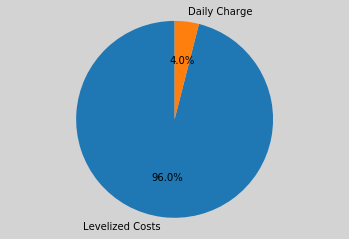

Total roof area of the  building: 599 m2
Total roof area used 508 m2
Percentage: 84.8%
succes
[[125.83138965254034, 91.26559145734917, 264.86403816696793, 21.24624250819528, 42.594073442478035, 29.23269621722401, 0.6363887783380773, 0.7884757584190896, 0.45046205699259645, 3342.1, 323.095, 323.095, 0.0, 0.0, {'Levelized Costs': 3209.037, 'Energy Charge': 0.021000000000185537, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601339870096, 61845.7, 507.7]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (123.43395159370333, 121.02553206529419, 241.24174460076148, 46.063504765181904, 36.706029606210194, 42.89487148686181, 0.2722073235101343, 0.432686201124733, 0.701995438277492)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 123
                                           a tilt of 46.1
                                           and a gcr of 0.272


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9719579219818115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 36.7
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.837559223175049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 42.9
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.911431074142456 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 147s


ERROR:ga_logger:panel relevance: [0.0, 96.3833, 263.955]


ERROR:ga_logger:Cost: 3712.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,712 per year


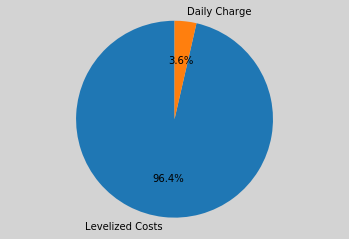

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[123.43395159370333, 121.02553206529419, 241.24174460076148, 46.063504765181904, 36.706029606210194, 42.89487148686181, 0.2722073235101343, 0.432686201124733, 0.701995438277492, 3712.0, 360.3383, 0.0, 96.3833, 263.955, {'Levelized Costs': 3578.938, 'Energy Charge': 0.020000000000038654, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60262039993, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.4144618491744, 259.4176510758434, 140.22266685282068, 25.898747714430367, 37.16406684231748, 48.52929448633876, 0.46450917881283316, 0.6737381889498755, 0.2938006679590923)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 254
                                           a tilt of 25.9
                                           and a gcr of 0.465


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0201244354248047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 259
                                           a tilt of 37.2
                                           and a gcr of 0.674


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8396623134613037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 48.5
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8688807487487793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 143s


ERROR:ga_logger:panel relevance: [41.381, 343.388, 0.0]


ERROR:ga_logger:Cost: 3954.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,955 per year


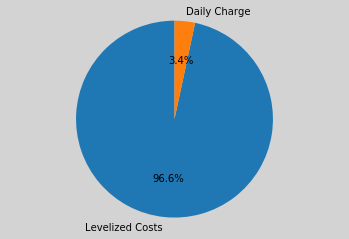

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[254.4144618491744, 259.4176510758434, 140.22266685282068, 25.898747714430367, 37.16406684231748, 48.52929448633876, 0.46450917881283316, 0.6737381889498755, 0.2938006679590923, 3954.66, 384.769, 41.381, 343.388, 0.0, {'Levelized Costs': 3821.5979999999995, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59902671805, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (176.05818107151453, 169.07819676991363, 144.95298050803706, 35.31027628023684, 29.461546244268153, 51.71429198375262, 0.5324327090119718, 0.645641223831814, 0.2843027534751578)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 35.3
                                           and a gcr of 0.532


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.9176957607269287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 29.5
                                           and a gcr of 0.646


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9069740772247314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 51.7
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.922551393508911 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 321 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 130s


ERROR:ga_logger:panel relevance: [297.816, 0.0, 0.0]


ERROR:ga_logger:Cost: 3091.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,091 per year


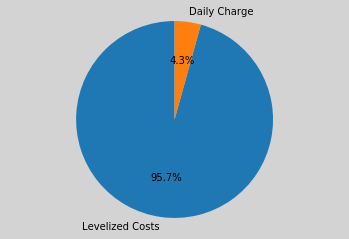

Total roof area of the  building: 599 m2
Total roof area used 559 m2
Percentage: 93.4%
succes
[[176.05818107151453, 169.07819676991363, 144.95298050803706, 35.31027628023684, 29.461546244268153, 51.71429198375262, 0.5324327090119718, 0.645641223831814, 0.2843027534751578, 3091.02, 297.816, 297.816, 0.0, 0.0, {'Levelized Costs': 2957.9610000000002, 'Energy Charge': 0.016999999999825377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60109274999, 61845.7, 559.349]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (219.0240029570276, 239.042148027777, 252.98957177612627, 49.00858991122191, 2.3811099950341053, 35.42996856451918, 0.5252290633794945, 0.7037874953856567, 0.7870937594149112)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 219
                                           a tilt of 49.0
                                           and a gcr of 0.525


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0155487060546875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 239
                                           a tilt of 2.4
                                           and a gcr of 0.704


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.745288610458374 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 35.4
                                           and a gcr of 0.787


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.94930100440979 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in 222 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 333.245, 0.0]


ERROR:ga_logger:Cost: 3442.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,443 per year


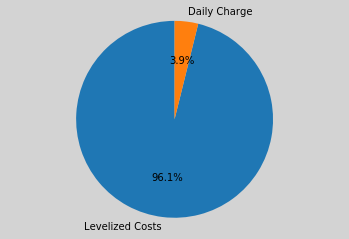

Total roof area of the  building: 599 m2
Total roof area used 474 m2
Percentage: 79.1%
succes
[[219.0240029570276, 239.042148027777, 252.98957177612627, 49.00858991122191, 2.3811099950341053, 35.42996856451918, 0.5252290633794945, 0.7037874953856567, 0.7870937594149112, 3442.91, 333.245, 0.0, 333.245, 0.0, {'Levelized Costs': 3309.8559999999998, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601752465845, 61845.7, 473.502]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (214.19343152052343, 92.19370185189537, 129.1435346908323, 47.60351534311996, 12.850669978519623, 37.56723173330091, 0.6632388217530505, 0.7186247156315202, 0.3837266342961494)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 47.6
                                           and a gcr of 0.663


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9552881717681885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 12.9
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.84804105758667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 129
                                           a tilt of 37.6
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9299068450927734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 283s


ERROR:ga_logger:panel relevance: [242.481, 0.0, 89.4696]


ERROR:ga_logger:Cost: 3430.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,430 per year


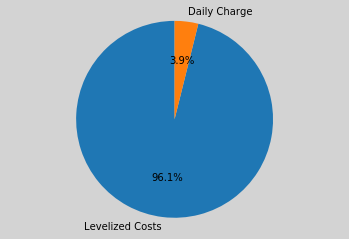

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[214.19343152052343, 92.19370185189537, 129.1435346908323, 47.60351534311996, 12.850669978519623, 37.56723173330091, 0.6632388217530505, 0.7186247156315202, 0.3837266342961494, 3430.06, 331.9506, 242.481, 0.0, 89.4696, {'Levelized Costs': 3297.007, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60355487999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.0109824130546, 173.91847905296328, 213.3056206045605, 25.538004063271995, 44.68001142752407, 6.176582172324567, 0.2222708200741425, 0.39746356676276207, 0.8444412672144095)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 25.5
                                           and a gcr of 0.222


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.05687141418457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 44.7
                                           and a gcr of 0.397


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.91552472114563 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 6.2
                                           and a gcr of 0.844


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5742368698120117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  19 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 140 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 173.747, 136.481]


ERROR:ga_logger:Cost: 3214.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,214 per year


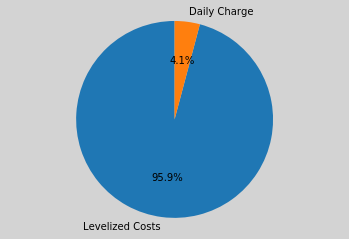

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.0109824130546, 173.91847905296328, 213.3056206045605, 25.538004063271995, 44.68001142752407, 6.176582172324567, 0.2222708200741425, 0.39746356676276207, 0.8444412672144095, 3214.3, 310.228, 0.0, 173.747, 136.481, {'Levelized Costs': 3081.245, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111794551, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.7109666437482, 188.88157649556146, 224.801415072378, 52.4507945298569, 29.06912998525751, 22.66898728587991, 0.7168017889066789, 0.6925891924629612, 0.6752761328591326)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 52.5
                                           and a gcr of 0.717


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.188419818878174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 29.1
                                           and a gcr of 0.693


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9151666164398193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 22.7
                                           and a gcr of 0.675


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9042325019836426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 163s


ERROR:ga_logger:panel relevance: [0.0, 304.141, 0.0]


ERROR:ga_logger:Cost: 3153.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,154 per year


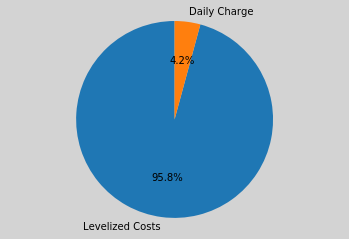

Total roof area of the  building: 599 m2
Total roof area used 439 m2
Percentage: 73.3%
succes
[[258.7109666437482, 188.88157649556146, 224.801415072378, 52.4507945298569, 29.06912998525751, 22.66898728587991, 0.7168017889066789, 0.6925891924629612, 0.6752761328591326, 3153.84, 304.141, 0.0, 304.141, 0.0, {'Levelized Costs': 3020.7830000000004, 'Energy Charge': 0.014999999999986358, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59930774897, 61845.7, 439.136]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (102.77537824025099, 115.28843514370035, 217.74486071302186, 38.410855339088016, 17.00133959997234, 34.82269264961519, 0.4182598703455879, 0.454226789705858, 0.5634315222382444)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 38.4
                                           and a gcr of 0.418


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.058347940444946 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 17.0
                                           and a gcr of 0.454


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.89644455909729 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 218
                                           a tilt of 34.8
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9861440658569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 287 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.096]


ERROR:ga_logger:Cost: 3272.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,273 per year


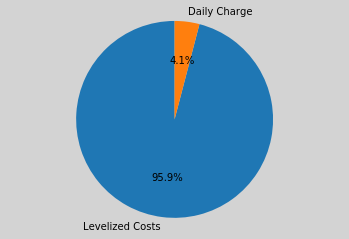

Total roof area of the  building: 599 m2
Total roof area used 561 m2
Percentage: 93.7%
succes
[[102.77537824025099, 115.28843514370035, 217.74486071302186, 38.410855339088016, 17.00133959997234, 34.82269264961519, 0.4182598703455879, 0.454226789705858, 0.5634315222382444, 3272.58, 316.096, 0.0, 0.0, 316.096, {'Levelized Costs': 3139.522, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60340026545, 61845.7, 561.019]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (256.83266416774853, 156.58106953152188, 188.6400295916762, 8.846260400008576, 50.390444350025405, 13.69352988413456, 0.616436610362149, 0.8093364285248414, 0.6562746336013462)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 8.8
                                           and a gcr of 0.616


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7550201416015625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 50.4
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.937323808670044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 13.7
                                           and a gcr of 0.656


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6366477012634277 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.455]


ERROR:ga_logger:Cost: 3196.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,197 per year


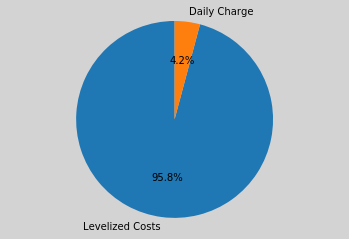

Total roof area of the  building: 599 m2
Total roof area used 470 m2
Percentage: 78.5%
succes
[[256.83266416774853, 156.58106953152188, 188.6400295916762, 8.846260400008576, 50.390444350025405, 13.69352988413456, 0.616436610362149, 0.8093364285248414, 0.6562746336013462, 3196.69, 308.455, 0.0, 0.0, 308.455, {'Levelized Costs': 3063.6360000000004, 'Energy Charge': 0.011999999999716238, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59964219124, 61845.7, 470.008]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.1801545861734, 209.2718862030234, 122.65732239258548, 46.72444709581919, 14.933459744041931, 36.62593269092984, 0.524003886005725, 0.31714752017658526, 0.3648946236949937)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 46.7
                                           and a gcr of 0.524


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.08367133140564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 14.9
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0224671363830566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 123
                                           a tilt of 36.6
                                           and a gcr of 0.365


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9941701889038086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 218.485]


ERROR:ga_logger:Cost: 4799.63


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0404 /kWh
Total Cost of the system: $ 4,800 per year


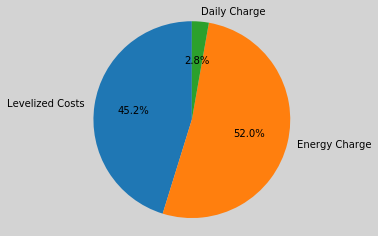

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[258.1801545861734, 209.2718862030234, 122.65732239258548, 46.72444709581919, 14.933459744041931, 36.62593269092984, 0.524003886005725, 0.31714752017658526, 0.3648946236949937, 4799.63, 218.485, 0.0, 0.0, 218.485, {'Levelized Costs': 2170.0409999999997, 'Energy Charge': 2496.5470000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 41921.15852613009, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (209.90822324771494, 99.55029640328121, 249.63257093923764, 25.325634686215782, 37.02291046096815, 39.285494121791366, 0.3433345071864808, 0.3540715194482965, 0.46083851174117624)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 25.3
                                           and a gcr of 0.343


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 66.26662230491638 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 37.0
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.03238582611084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 39.3
                                           and a gcr of 0.461


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2656822204589844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  74 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 275.932]


ERROR:ga_logger:Cost: 4584.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0277 /kWh
Total Cost of the system: $ 4,584 per year


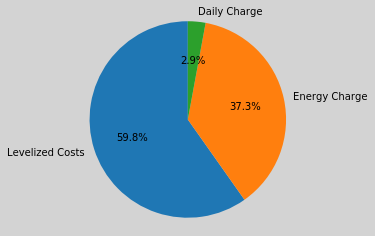

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[209.90822324771494, 99.55029640328121, 249.63257093923764, 25.325634686215782, 37.02291046096815, 39.285494121791366, 0.3433345071864808, 0.3540715194482965, 0.46083851174117624, 4584.08, 275.932, 0.0, 0.0, 275.932, {'Levelized Costs': 2740.612, 'Energy Charge': 1710.426, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 48195.0704121013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.09220904338497, 111.2395303627274, 185.9657105182016, 5.069266920715101, 47.99580599503534, 27.111780889539002, 0.44903652826907636, 0.5202872497032363, 0.7987021121297335)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 5.1
                                           and a gcr of 0.449


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.064335823059082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 111
                                           a tilt of 48.0
                                           and a gcr of 0.520


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9589693546295166 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 27.1
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.049842119216919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 138 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.119]


ERROR:ga_logger:Cost: 3213.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,213 per year


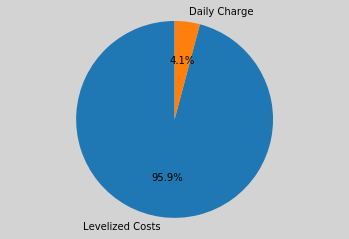

Total roof area of the  building: 599 m2
Total roof area used 388 m2
Percentage: 64.8%
succes
[[136.09220904338497, 111.2395303627274, 185.9657105182016, 5.069266920715101, 47.99580599503534, 27.111780889539002, 0.44903652826907636, 0.5202872497032363, 0.7987021121297335, 3213.22, 310.119, 0.0, 0.0, 310.119, {'Levelized Costs': 3080.1549999999993, 'Energy Charge': 0.02300000000059299, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601579381044, 61845.7, 388.279]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (226.39165888414703, 247.5713757345606, 165.23915432110186, 30.69886064377823, 1.209436499843891, 27.306401639889497, 0.7130809986118878, 0.8738061283448775, 0.8368938049525267)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 30.7
                                           and a gcr of 0.713


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.003329277038574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 1.2
                                           and a gcr of 0.874


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.581855058670044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 27.3
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8852598667144775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 152 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 158s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.933]


ERROR:ga_logger:Cost: 3290.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,291 per year


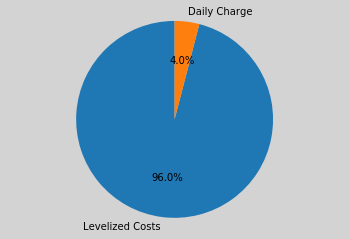

Total roof area of the  building: 599 m2
Total roof area used 380 m2
Percentage: 63.4%
succes
[[226.39165888414703, 247.5713757345606, 165.23915432110186, 30.69886064377823, 1.209436499843891, 27.306401639889497, 0.7130809986118878, 0.8738061283448775, 0.8368938049525267, 3290.83, 317.933, 0.0, 0.0, 317.933, {'Levelized Costs': 3157.7749999999996, 'Energy Charge': 0.013000000000261025, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601467075634, 61845.7, 379.896]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.636285597723, 149.8267995871211, 178.54977894847377, 7.616069807988597, 4.5812696424714545, 36.26555304960654, 0.7102745499557133, 0.3742539955979812, 0.2099420845779445)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 7.6
                                           and a gcr of 0.710


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9534566402435303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 4.6
                                           and a gcr of 0.374


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 76.2450909614563 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 36.3
                                           and a gcr of 0.210


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.061858892440796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  84 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 239s


ERROR:ga_logger:panel relevance: [266.346, 0.0, 46.9791]


ERROR:ga_logger:Cost: 3245.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


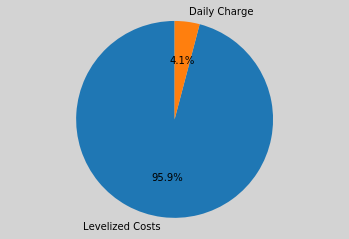

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[178.636285597723, 149.8267995871211, 178.54977894847377, 7.616069807988597, 4.5812696424714545, 36.26555304960654, 0.7102745499557133, 0.3742539955979812, 0.2099420845779445, 3245.06, 313.3251, 266.346, 0.0, 46.9791, {'Levelized Costs': 3112.001, 'Energy Charge': 0.01699999999988222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60093646811, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.26626157654972, 180.67832227860038, 195.8799360363521, 2.1954027085453296, 11.680823612465302, 17.881709140515618, 0.758085826878981, 0.36293490131874684, 0.6289891425558516)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 2.2
                                           and a gcr of 0.758


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.923207998275757 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 181
                                           a tilt of 11.7
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.971924066543579 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 17.9
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.293069839477539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  84 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.532]


ERROR:ga_logger:Cost: 3167.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,168 per year


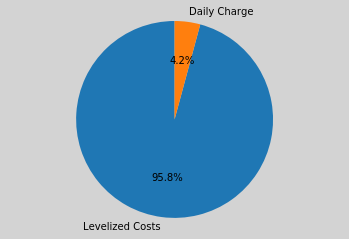

Total roof area of the  building: 599 m2
Total roof area used 486 m2
Percentage: 81.1%
succes
[[118.26626157654972, 180.67832227860038, 195.8799360363521, 2.1954027085453296, 11.680823612465302, 17.881709140515618, 0.758085826878981, 0.36293490131874684, 0.6289891425558516, 3167.66, 305.532, 0.0, 0.0, 305.532, {'Levelized Costs': 3034.604, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600868161404, 61845.7, 485.75]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.69972142423305, 255.55175192765523, 263.6681148005756, 1.1975329172679574, 27.931631132694484, 32.504823247146774, 0.40320116416005164, 0.3801849969604436, 0.8235985203353531)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 1.2
                                           and a gcr of 0.403


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 7.233110666275024 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 27.9
                                           and a gcr of 0.380


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.930781602859497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 32.5
                                           and a gcr of 0.824


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.93782639503479 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 148 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [102.387, 0.0, 283.999]


ERROR:ga_logger:Cost: 3970.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,971 per year


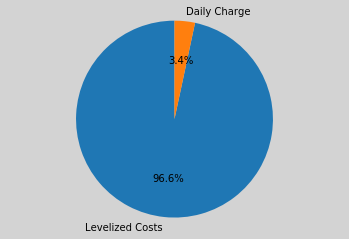

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[254.69972142423305, 255.55175192765523, 263.6681148005756, 1.1975329172679574, 27.931631132694484, 32.504823247146774, 0.40320116416005164, 0.3801849969604436, 0.8235985203353531, 3970.72, 386.386, 102.387, 0.0, 283.999, {'Levelized Costs': 3837.6659999999997, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60174207522, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (252.42400272161632, 100.55372300645173, 219.6913826685931, 7.637204247341385, 38.02348926777609, 42.764324237100965, 0.7042664001142556, 0.8303649519885372, 0.5981872998502895)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 7.6
                                           and a gcr of 0.704


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.202071189880371 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 38.0
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.96065616607666 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 42.8
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9313809871673584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 186 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 329.912]


ERROR:ga_logger:Cost: 3409.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,410 per year


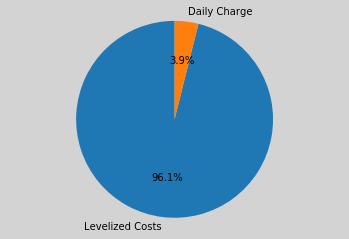

Total roof area of the  building: 599 m2
Total roof area used 552 m2
Percentage: 92.1%
succes
[[252.42400272161632, 100.55372300645173, 219.6913826685931, 7.637204247341385, 38.02348926777609, 42.764324237100965, 0.7042664001142556, 0.8303649519885372, 0.5981872998502895, 3409.81, 329.912, 0.0, 0.0, 329.912, {'Levelized Costs': 3276.7569999999996, 'Energy Charge': 0.011000000000308319, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60135069854, 61845.7, 551.519]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.7124671101072, 146.2218628174158, 216.48167227683797, 48.49239009284594, 35.280172930132245, 30.967709209294366, 0.22651488086817997, 0.7948460215928015, 0.3788111697427697)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 244
                                           a tilt of 48.5
                                           and a gcr of 0.227


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9134764671325684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 35.3
                                           and a gcr of 0.795


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.92116641998291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 31.0
                                           and a gcr of 0.379


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.934858798980713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 150 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 177.985, 141.993]


ERROR:ga_logger:Cost: 3311.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,311 per year


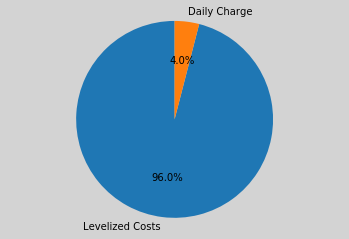

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[243.7124671101072, 146.2218628174158, 216.48167227683797, 48.49239009284594, 35.280172930132245, 30.967709209294366, 0.22651488086817997, 0.7948460215928015, 0.3788111697427697, 3311.14, 319.978, 0.0, 177.985, 141.993, {'Levelized Costs': 3178.082, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604013507545, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


--- Logging error ---
Traceback (most recent call last):
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 996, in emit
    self.flush()
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/logging/__init__.py", line 976, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cvmfs/soft.computecanada.ca/easybuild/software/2017/Core/python/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/theochri/paper_pusher/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
  

ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 14.1
                                           and a gcr of 0.348


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.77347993850708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 25.7
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.979870319366455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 152
                                           a tilt of 45.3
                                           and a gcr of 0.595


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.87880277633667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 302.422, 0.0]


ERROR:ga_logger:Cost: 3136.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


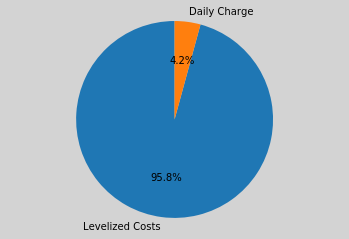

Total roof area of the  building: 599 m2
Total roof area used 508 m2
Percentage: 84.9%
succes
[[143.27808517332963, 198.70626796807227, 151.5626096271483, 14.054843163318075, 25.73690234886504, 45.33817888070378, 0.348170229003989, 0.5949213949441667, 0.59453901770734, 3136.77, 302.422, 0.0, 302.422, 0.0, {'Levelized Costs': 3003.7149999999997, 'Energy Charge': 0.013000000000374712, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60280181771, 61845.7, 508.34]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (246.98499423166868, 103.39998629307081, 162.4730887415837, 39.87702792901421, 33.33395028264433, 21.64914578189922, 0.49733640287000175, 0.8621999133200979, 0.4906585064012593)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 247
                                           a tilt of 39.9
                                           and a gcr of 0.497


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0476133823394775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 103
                                           a tilt of 33.3
                                           and a gcr of 0.862


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9461400508880615 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 21.6
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.017426013946533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  83 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 139 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 33.1112, 274.945]


ERROR:ga_logger:Cost: 3192.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,193 per year


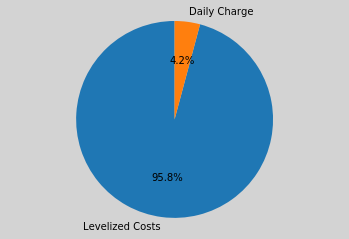

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[246.98499423166868, 103.39998629307081, 162.4730887415837, 39.87702792901421, 33.33395028264433, 21.64914578189922, 0.49733640287000175, 0.8621999133200979, 0.4906585064012593, 3192.73, 308.0562, 0.0, 33.1112, 274.945, {'Levelized Costs': 3059.68, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60255721982, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (189.48931226942068, 249.97301264030332, 137.88420495709732, 41.09582217731636, 35.00783237488052, 27.77723770099402, 0.5888385158240859, 0.5899635043673968, 0.7278547256872194)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 41.1
                                           and a gcr of 0.589


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.225223064422607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 35.0
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9941515922546387 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 27.8
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9197800159454346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 148s


ERROR:ga_logger:panel relevance: [304.391, 0.0, 0.0]


ERROR:ga_logger:Cost: 3156.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,156 per year


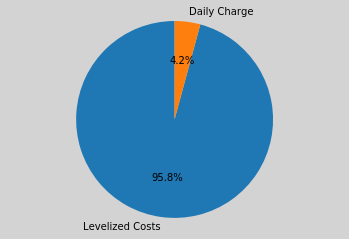

Total roof area of the  building: 599 m2
Total roof area used 517 m2
Percentage: 86.3%
succes
[[189.48931226942068, 249.97301264030332, 137.88420495709732, 41.09582217731636, 35.00783237488052, 27.77723770099402, 0.5888385158240859, 0.5899635043673968, 0.7278547256872194, 3156.33, 304.391, 304.391, 0.0, 0.0, {'Levelized Costs': 3023.278, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600403309436, 61845.7, 516.935]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.6706627916975, 222.3621706468492, 100.28023816122906, 9.948456551108274, 45.80537496707986, 33.80822557369572, 0.5717751506606303, 0.7774948466814919, 0.2395524985058824)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 9.9
                                           and a gcr of 0.572


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.101019859313965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 45.8
                                           and a gcr of 0.777


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.948871612548828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 33.8
                                           and a gcr of 0.240


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9800169467926025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [324.93, 0.0, 0.0]


ERROR:ga_logger:Cost: 3360.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,360 per year


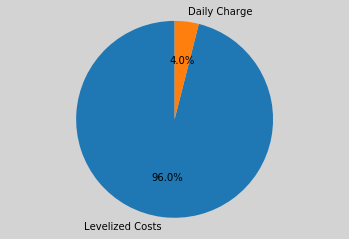

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.9%
succes
[[117.6706627916975, 222.3621706468492, 100.28023816122906, 9.948456551108274, 45.80537496707986, 33.80822557369572, 0.5717751506606303, 0.7774948466814919, 0.2395524985058824, 3360.32, 324.93, 324.93, 0.0, 0.0, {'Levelized Costs': 3227.268, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60226941019, 61845.7, 568.282]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (250.87874373238992, 126.52980462137307, 156.07637611523, 29.703403184227394, 47.74232958608767, 48.0310686689529, 0.398854017720217, 0.3167916633231324, 0.22501247407505404)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 29.7
                                           and a gcr of 0.399


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1590840816497803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 47.7
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.078064441680908 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 156
                                           a tilt of 48.0
                                           and a gcr of 0.225


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9768905639648438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 272 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [238.819, 0.0, 0.0]


ERROR:ga_logger:Cost: 4794.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0370 /kWh
Total Cost of the system: $ 4,795 per year


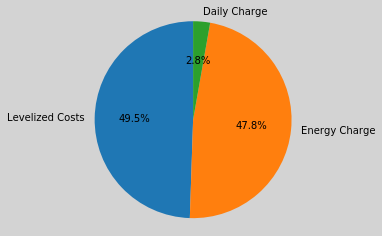

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[250.87874373238992, 126.52980462137307, 156.07637611523, 29.703403184227394, 47.74232958608767, 48.0310686689529, 0.398854017720217, 0.3167916633231324, 0.22501247407505404, 4794.7, 238.819, 238.819, 0.0, 0.0, {'Levelized Costs': 2371.9912999999992, 'Energy Charge': 2289.6667000000007, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 43572.238824209984, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (231.53483379892037, 165.66331119114415, 161.3355607723035, 1.2548465741316792, 21.872389136004067, 48.13027780991137, 0.4827238587352652, 0.21351900921741956, 0.5291980798609532)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 1.3
                                           and a gcr of 0.483


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.800764322280884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 21.9
                                           and a gcr of 0.214


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9524147510528564 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 48.1
                                           and a gcr of 0.529


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8953819274902344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 151 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 154s


ERROR:ga_logger:panel relevance: [0.0, 2.2652, 311.249]


ERROR:ga_logger:Cost: 3246.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,247 per year


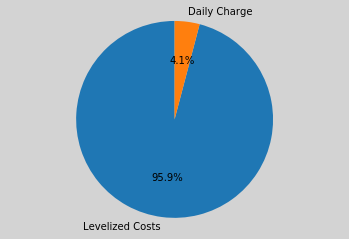

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[231.53483379892037, 165.66331119114415, 161.3355607723035, 1.2548465741316792, 21.872389136004067, 48.13027780991137, 0.4827238587352652, 0.21351900921741956, 0.5291980798609532, 3246.95, 313.5142, 0.0, 2.2652, 311.249, {'Levelized Costs': 3113.8909999999996, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602654399896, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (198.60211852545032, 127.48457156695078, 127.11446406685707, 29.142092060227856, 33.00862926075367, 31.935110203015594, 0.5763572365125973, 0.5255662522034386, 0.31261906861576905)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 29.1
                                           and a gcr of 0.576


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0434677600860596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 33.0
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8940091133117676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 127
                                           a tilt of 31.9
                                           and a gcr of 0.313


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0183265209198 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 190 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 145s


ERROR:ga_logger:panel relevance: [301.661, 0.0, 0.0]


ERROR:ga_logger:Cost: 3129.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,129 per year


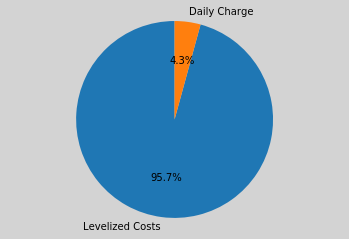

Total roof area of the  building: 599 m2
Total roof area used 523 m2
Percentage: 87.4%
succes
[[198.60211852545032, 127.48457156695078, 127.11446406685707, 29.142092060227856, 33.00862926075367, 31.935110203015594, 0.5763572365125973, 0.5255662522034386, 0.31261906861576905, 3129.21, 301.661, 301.661, 0.0, 0.0, {'Levelized Costs': 2996.154, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149892069, 61845.7, 523.392]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (248.32927525080402, 201.65210947588963, 103.64698469844456, 14.033559149417004, 41.07463946776118, 21.92982039980929, 0.20378922480115924, 0.800174117766256, 0.5955314436615482)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 248
                                           a tilt of 14.0
                                           and a gcr of 0.204


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.249030113220215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 41.1
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941129684448242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 104
                                           a tilt of 21.9
                                           and a gcr of 0.596


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9072275161743164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 149 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 221s


ERROR:ga_logger:panel relevance: [51.2421, 277.913, 0.0]


ERROR:ga_logger:Cost: 3402.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,402 per year


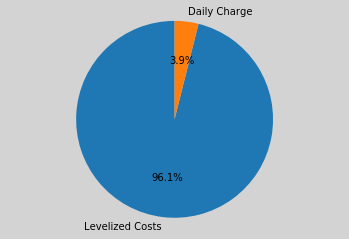

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[248.32927525080402, 201.65210947588963, 103.64698469844456, 14.033559149417004, 41.07463946776118, 21.92982039980929, 0.20378922480115924, 0.800174117766256, 0.5955314436615482, 3402.29, 329.1551, 51.2421, 277.913, 0.0, {'Levelized Costs': 3269.238, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601215641225, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145.18764531240583, 123.90454332113696, 153.99091671082246, 52.13385805293288, 18.78233117691363, 45.704700369891206, 0.7007815679849712, 0.2839876787311263, 0.39851312227319313)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 52.1
                                           and a gcr of 0.701


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0648045539855957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 18.8
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9147469997406006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 45.7
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.011681318283081 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [221.308, 0.0, 112.763]


ERROR:ga_logger:Cost: 3451.12


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,451 per year


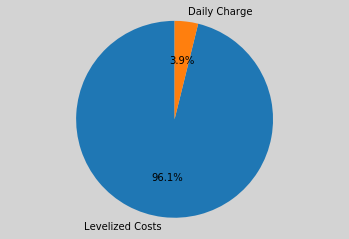

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[145.18764531240583, 123.90454332113696, 153.99091671082246, 52.13385805293288, 18.78233117691363, 45.704700369891206, 0.7007815679849712, 0.2839876787311263, 0.39851312227319313, 3451.12, 334.071, 221.308, 0.0, 112.763, {'Levelized Costs': 3318.066, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59944023, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (218.18550369819073, 95.8408875566191, 164.08193336462926, 49.63497565181012, 51.509390785661324, 42.70283866619215, 0.25662125279864145, 0.6014083826916998, 0.23598529979204463)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 218
                                           a tilt of 49.6
                                           and a gcr of 0.257


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0125350952148438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 51.5
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.95754337310791 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 42.7
                                           and a gcr of 0.236


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0384974479675293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 164 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 360.1, 0.0]


ERROR:ga_logger:Cost: 5039.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0215 /kWh
Total Cost of the system: $ 5,040 per year


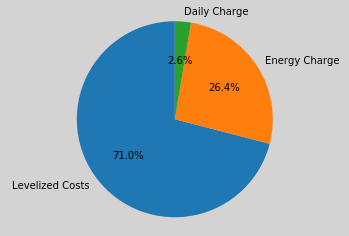

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[218.18550369819073, 95.8408875566191, 164.08193336462926, 49.63497565181012, 51.509390785661324, 42.70283866619215, 0.25662125279864145, 0.6014083826916998, 0.23598529979204463, 5039.89, 360.1, 0.0, 360.1, 0.0, {'Levelized Costs': 3576.5930000000003, 'Energy Charge': 1330.255, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51229.1446782999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.2695626758113, 162.93048997144587, 147.0285489607351, 44.494510124234914, 6.059843176475748, 42.729486626567564, 0.8321488328196907, 0.45076899892099376, 0.4342795791776526)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 44.5
                                           and a gcr of 0.832


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.042757511138916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 6.1
                                           and a gcr of 0.451


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9967219829559326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 147
                                           a tilt of 42.7
                                           and a gcr of 0.434


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9639766216278076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 220 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 260.03]


ERROR:ga_logger:Cost: 3964.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0202 /kWh
Total Cost of the system: $ 3,964 per year


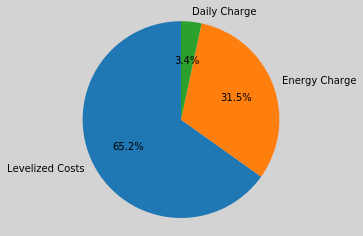

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[257.2695626758113, 162.93048997144587, 147.0285489607351, 44.494510124234914, 6.059843176475748, 42.729486626567564, 0.8321488328196907, 0.45076899892099376, 0.4342795791776526, 3964.13, 260.03, 0.0, 0.0, 260.03, {'Levelized Costs': 2582.668, 'Energy Charge': 1248.42, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51882.267381679834, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.88003802271945, 114.14186103945374, 198.22985025288028, 18.848777035453153, 6.893021860492452, 35.91338979274305, 0.6975804000832084, 0.5150878396990455, 0.6795134443799958)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 18.8
                                           and a gcr of 0.698


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0418455600738525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 6.9
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.884009838104248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 35.9
                                           and a gcr of 0.680


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.933286666870117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 177 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.765]


ERROR:ga_logger:Cost: 3219.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,220 per year


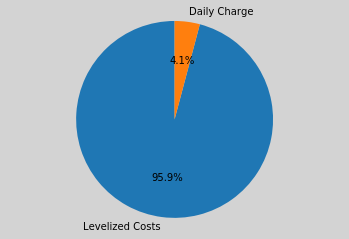

Total roof area of the  building: 599 m2
Total roof area used 457 m2
Percentage: 76.4%
succes
[[112.88003802271945, 114.14186103945374, 198.22985025288028, 18.848777035453153, 6.893021860492452, 35.91338979274305, 0.6975804000832084, 0.5150878396990455, 0.6795134443799958, 3219.64, 310.765, 0.0, 0.0, 310.765, {'Levelized Costs': 3086.582, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60153203465, 61845.7, 457.335]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (92.39387184306052, 211.53646559734182, 166.7634755129569, 31.04456745522122, 33.203962823355326, 44.25285658721742, 0.5517652905860442, 0.5244238330326083, 0.44546194324318533)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 31.0
                                           and a gcr of 0.552


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9039881229400635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 33.2
                                           and a gcr of 0.524


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8864564895629883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 44.3
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8645994663238525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 182 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 153s


ERROR:ga_logger:panel relevance: [0.0, 269.178, 38.0777]


ERROR:ga_logger:Cost: 3184.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,185 per year


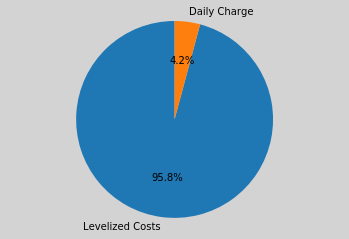

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[92.39387184306052, 211.53646559734182, 166.7634755129569, 31.04456745522122, 33.203962823355326, 44.25285658721742, 0.5517652905860442, 0.5244238330326083, 0.44546194324318533, 3184.78, 307.2557, 0.0, 269.178, 38.0777, {'Levelized Costs': 3051.718, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601948634496, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (101.50249405021232, 151.49446970104515, 219.67590724745966, 24.37217035643191, 7.2340183523752115, 43.04143104626132, 0.45887790198297973, 0.8581519154559198, 0.4670653637741)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 102
                                           a tilt of 24.4
                                           and a gcr of 0.459


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0178439617156982 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 7.2
                                           and a gcr of 0.858


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.88976788520813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 43.0
                                           and a gcr of 0.467


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9755218029022217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 155s


ERROR:ga_logger:panel relevance: [0.0, 91.4897, 229.866]


ERROR:ga_logger:Cost: 3324.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


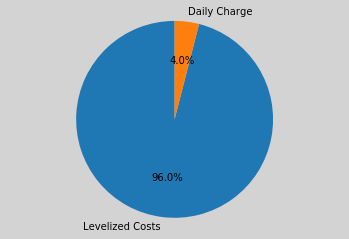

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[101.50249405021232, 151.49446970104515, 219.67590724745966, 24.37217035643191, 7.2340183523752115, 43.04143104626132, 0.45887790198297973, 0.8581519154559198, 0.4670653637741, 3324.82, 321.3557, 0.0, 91.4897, 229.866, {'Levelized Costs': 3191.7590000000005, 'Energy Charge': 0.01899999999989177, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6007844405, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (131.48181604759446, 118.38698019969556, 239.27064350050205, 5.6687953925268335, 53.289435000693686, 14.298384391718763, 0.6161256000158019, 0.5325612578211707, 0.3966369059842431)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 131
                                           a tilt of 5.7
                                           and a gcr of 0.616


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0167202949523926 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 118
                                           a tilt of 53.3
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.94069242477417 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 239
                                           a tilt of 14.3
                                           and a gcr of 0.397


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1186251640319824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 143 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [245.626, 0.0, 79.3669]


ERROR:ga_logger:Cost: 3360.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,361 per year


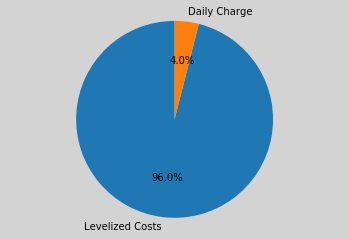

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[131.48181604759446, 118.38698019969556, 239.27064350050205, 5.6687953925268335, 53.289435000693686, 14.298384391718763, 0.6161256000158019, 0.5325612578211707, 0.3966369059842431, 3360.95, 324.9929, 245.626, 0.0, 79.3669, {'Levelized Costs': 3227.8849999999998, 'Energy Charge': 0.023000000000365617, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60185671281, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.8884327322986, 108.79957425841813, 96.18495321151373, 49.692525415400915, 34.20236364880777, 15.880605989299983, 0.6887126375762496, 0.8540434266512698, 0.48842999691720346)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 49.7
                                           and a gcr of 0.689


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0765323638916016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 34.2
                                           and a gcr of 0.854


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9143755435943604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 96
                                           a tilt of 15.9
                                           and a gcr of 0.488


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.140061378479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  75 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 146 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 154.648, 204.009]


ERROR:ga_logger:Cost: 3695.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,695 per year


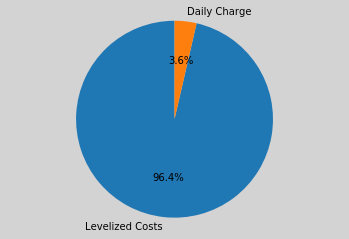

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[261.8884327322986, 108.79957425841813, 96.18495321151373, 49.692525415400915, 34.20236364880777, 15.880605989299983, 0.6887126375762496, 0.8540434266512698, 0.48842999691720346, 3695.32, 358.657, 0.0, 154.648, 204.009, {'Levelized Costs': 3562.270000000001, 'Energy Charge': 0.007999999999583451, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60218850004, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.37359921225715, 150.51282392084227, 109.15233948163784, 28.03020996248783, 6.488789465525245, 19.214471568762065, 0.7389051811293832, 0.3358259909020948, 0.665003296700192)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 167
                                           a tilt of 28.0
                                           and a gcr of 0.739


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9899771213531494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 6.5
                                           and a gcr of 0.336


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9012551307678223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 19.2
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9316439628601074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [308.974, 0.0, 0.0]


ERROR:ga_logger:Cost: 3201.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,202 per year


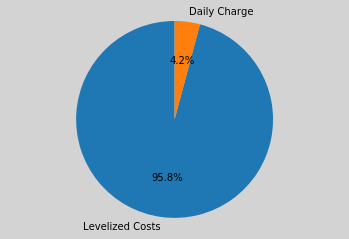

Total roof area of the  building: 599 m2
Total roof area used 418 m2
Percentage: 69.8%
succes
[[167.37359921225715, 150.51282392084227, 109.15233948163784, 28.03020996248783, 6.488789465525245, 19.214471568762065, 0.7389051811293832, 0.3358259909020948, 0.665003296700192, 3201.85, 308.974, 308.974, 0.0, 0.0, {'Levelized Costs': 3068.797, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60087481636, 61845.7, 418.151]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (191.49850517302394, 193.7487917269489, 203.32976166097546, 41.31414370308505, 1.2405270379538593, 13.603354758995803, 0.5320532441794134, 0.4404193806716794, 0.4469593982661827)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 41.3
                                           and a gcr of 0.532


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9849231243133545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 1.2
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.696610450744629 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 13.6
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9686119556427 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [302.353, 0.0, 0.0]


ERROR:ga_logger:Cost: 3136.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,136 per year


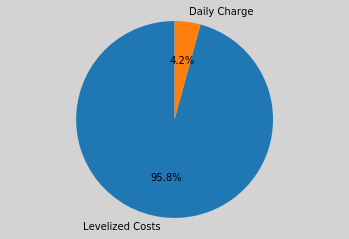

Total roof area of the  building: 599 m2
Total roof area used 568 m2
Percentage: 94.9%
succes
[[191.49850517302394, 193.7487917269489, 203.32976166097546, 41.31414370308505, 1.2405270379538593, 13.603354758995803, 0.5320532441794134, 0.4404193806716794, 0.4469593982661827, 3136.09, 302.353, 302.353, 0.0, 0.0, {'Levelized Costs': 3003.033, 'Energy Charge': 0.015000000000441105, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60313609017, 61845.7, 568.277]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (95.27940880272335, 174.397313465896, 101.27013217909442, 24.910824731430367, 9.39285679840529, 4.084090218515552, 0.5527076615640905, 0.8421338458779954, 0.2918649664089645)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 24.9
                                           and a gcr of 0.553


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9513583183288574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 9.4
                                           and a gcr of 0.842


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8510677814483643 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 4.1
                                           and a gcr of 0.292


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8730733394622803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 318.993, 0.0]


ERROR:ga_logger:Cost: 3301.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,301 per year


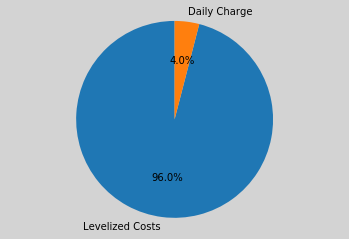

Total roof area of the  building: 599 m2
Total roof area used 379 m2
Percentage: 63.3%
succes
[[95.27940880272335, 174.397313465896, 101.27013217909442, 24.910824731430367, 9.39285679840529, 4.084090218515552, 0.5527076615640905, 0.8421338458779954, 0.2918649664089645, 3301.36, 318.993, 0.0, 318.993, 0.0, {'Levelized Costs': 3168.302, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60391157397, 61845.7, 378.791]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.442850632351, 101.68362998787876, 261.56771599500564, 52.92379803725133, 55.965508265813696, 44.53687907179036, 0.8127106518974005, 0.7029245762913428, 0.8294518592012157)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 117
                                           a tilt of 52.9
                                           and a gcr of 0.813


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.921872138977051 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 56.0
                                           and a gcr of 0.703


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8901822566986084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 262
                                           a tilt of 44.5
                                           and a gcr of 0.829


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.882711410522461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 253 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 164s


ERROR:ga_logger:panel relevance: [419.759, 0.0, 0.0]


ERROR:ga_logger:Cost: 4302.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,302 per year


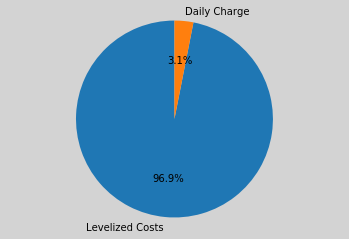

Total roof area of the  building: 599 m2
Total roof area used 516 m2
Percentage: 86.3%
succes
[[117.442850632351, 101.68362998787876, 261.56771599500564, 52.92379803725133, 55.965508265813696, 44.53687907179036, 0.8127106518974005, 0.7029245762913428, 0.8294518592012157, 4302.19, 419.759, 419.759, 0.0, 0.0, {'Levelized Costs': 4169.146, 'Energy Charge': 0.0019999999999527063, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59879700006, 61845.7, 516.493]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (154.75000269442972, 144.6880828531595, 234.23123073707407, 19.435261400073824, 23.052913829726172, 37.09799044412814, 0.3262598774258898, 0.4616250472606341, 0.7277958027671871)


Found the solver set


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation

ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 19.4
                                           and a gcr of 0.326


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.05383038520813 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 23.1
                                           and a gcr of 0.462


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.900416374206543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 37.1
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.943368673324585 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 197.826, 123.885]


ERROR:ga_logger:Cost: 3328.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,328 per year


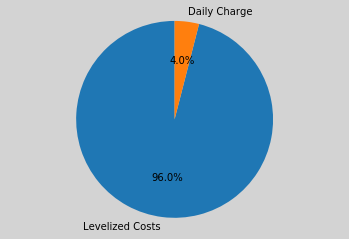

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[154.75000269442972, 144.6880828531595, 234.23123073707407, 19.435261400073824, 23.052913829726172, 37.09799044412814, 0.3262598774258898, 0.4616250472606341, 0.7277958027671871, 3328.35, 321.711, 0.0, 197.826, 123.885, {'Levelized Costs': 3195.296, 'Energy Charge': 0.012000000000398359, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60140911439, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (104.75502285362386, 129.36788215506516, 166.91774839386215, 28.238598257606732, 31.26974562374722, 37.252953092727594, 0.3672554270185731, 0.45295831657614155, 0.8842038720272662)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 28.2
                                           and a gcr of 0.367


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0157344341278076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 129
                                           a tilt of 31.3
                                           and a gcr of 0.453


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8970746994018555 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 37.3
                                           and a gcr of 0.884


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8867344856262207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 220.132, 99.7147]


ERROR:ga_logger:Cost: 3309.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,310 per year


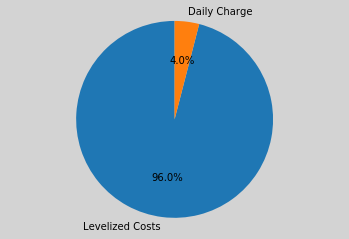

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[104.75502285362386, 129.36788215506516, 166.91774839386215, 28.238598257606732, 31.26974562374722, 37.252953092727594, 0.3672554270185731, 0.45295831657614155, 0.8842038720272662, 3309.84, 319.8467, 0.0, 220.132, 99.7147, {'Levelized Costs': 3176.789, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59992354996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.12457914122093, 179.73848960594344, 97.62160579969355, 9.671876348960387, 7.533930740122538, 24.016590203189466, 0.8477315825062595, 0.5867052903738588, 0.20842290790181853)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 9.7
                                           and a gcr of 0.848


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.983137369155884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 7.5
                                           and a gcr of 0.587


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.971702814102173 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 24.0
                                           and a gcr of 0.208


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940094470977783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  91 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 193 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 248s


ERROR:ga_logger:panel relevance: [0.0, 317.2, 0.0]


ERROR:ga_logger:Cost: 3283.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


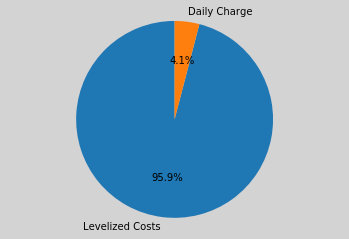

Total roof area of the  building: 599 m2
Total roof area used 541 m2
Percentage: 90.3%
succes
[[125.12457914122093, 179.73848960594344, 97.62160579969355, 9.671876348960387, 7.533930740122538, 24.016590203189466, 0.8477315825062595, 0.5867052903738588, 0.20842290790181853, 3283.55, 317.2, 0.0, 317.2, 0.0, {'Levelized Costs': 3150.493000000001, 'Energy Charge': 0.014999999999645297, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59937253077, 61845.7, 540.646]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 7 using opt-method ga-100 with 100 evalautions took: (min)


ERROR:Runs_logger:692.6699556152026


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)